# **Milestone 3: further data analysis moving towards the final goal!**

In [27]:
# We import our packages
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.graph_objects as go
import plotly

In [28]:
# Importing the final dataframe of Milestone 2
df = pd.read_pickle('Pickles/Final_dataframe.pickle')

# Sort by countries
df = df.sort_values("State").reset_index(drop=True)

In [29]:
import json
from pprint import pprint
from folium import FeatureGroup, LayerControl, Map, Marker
import copy

def build_map(output_file, df_map, columns, legend_name):
    """
    columns must have as first column the abbreviation for states, and as second column the feature measured
    """
    m = folium.Map(location=[48, -102], zoom_start=3)
    
    states_geo_full = json.load(open("Data/us-states_full.json"))

    json_us_states = {'type': 'FeatureCollection', 'features': []}

    counter = 0
    for el in states_geo_full['features']:
        if el['properties']['name'].lower() in df_education_final.State.values:
            el['properties']['name'] = el['properties']['name'].lower()
            el['id'] = df_education_final.loc[df_education_final['State'] == el['properties']['name'].lower()].iloc[0]['abbreviation']
            json_us_states['features'].append(el)
            counter += 1
    # A bit dirty here, in order to avoid changing pointers and so on we just make a copy recursively
    my_json = copy.deepcopy(json_us_states)
    
    # Here we have to add the feature to the json file!
    for i in range(len(df_map)):
        my_json['features'][i]['properties'][columns[1]] = float(df_map.iloc[i][columns[1]])
    
    folium.Choropleth(
        geo_data=my_json,
        name='choropleth',
        data=df_map[columns],
        columns=columns,
        key_on='feature.id',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)

    m.save(output_file)
    return m

In [30]:
def plot_plotly_scatter(x, y, marker, title, output_file, xlabel, ylabel):
    """
    plots an interactive scatterplot using plotly, and 
    saves to the destination html file desired
    """
    fig = go.Figure(data=go.Scatter(x=x,
                                    y=y,
                                    mode='markers',
                                    marker_color=x,
                                    text=marker)) # hover text goes here

    polyfit = np.poly1d(np.polyfit(x, y, 1))
    fig.add_shape(
            # Line Diagonal
            go.layout.Shape(
                type="line",
                x0=0,
                y0=polyfit[0],
                x1=np.max(x),
                y1=np.max(x) * polyfit[1] + polyfit[0],
                line=dict(
                    color="MediumPurple",
                    width=4,
                    dash="dot",
                )
    ))
    fig.update_layout(title=title,
                      xaxis_title=xlabel,
                      yaxis_title=ylabel)
    plotly.io.write_html(fig, output_file)

    fig.show()

In [31]:
import plotly.graph_objects as go

def build_heatmap(df, title, output_filename):
    """
    Creates a heatmap for the correlation columns selected
    """
    rows = df.columns

    columns = df.columns
    
    z = df.corr()

    fig = go.Figure(data=go.Heatmap(
            z=z,
            x=columns,
            y=rows,
            colorscale='Viridis'))

    fig.update_layout(
        title=title)

    fig.show()
    plotly.io.write_html(fig, output_filename)

# How ADA can help you to choose where to live
## A data analysis based on *quality of life* in the USA

In our lives, we must do some choices.
Probably, one of the most difficult ones is the place we want to live in. Of course the right environment is necessary to live the *life of our dreams*.
The *quality* of a place is something absolutely subjective and depends on personal factors, like "places of the heart", closeness to family and friends, possibility to do activities each person likes...

At the same time, we can underline some features that are **general and objective** when describing the *quality* of places: rate of education, health, security, income...
Basing on these features, sociologists tried to perform some indicative analysis to decide if some places are objectively better than others, and to select these places.

The **Human Development Index (HDI)** is a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores a higher HDI when the lifespan is higher, the education level is higher, and the gross national income GNI (PPP) per capita is higher. [1]

Basing on this universally recognised index, we want to personalize our analysis.
The classic HDI gives fixed weights to each feature. But every person has its own preferencies and necessities. Some people could consider the possibility of obtaining an high income as a must, while others would barter it with a longer and healthy life, or with security.
That is why we tried to find data for single categories: many sites offer dataset about different topics and different geographic areas.
We decided to focus on **USA** for different reasons: there are tons of data about whatever regarding USA, from both governative sites, research sites, universities and other sources; US are a country where it is possible to find huge differences between states about lifestyle, health, security, GDP; finally, USA are seen as a classical country where to live, so our analysis could be socially useful!

In our analysis we selected data from different sources (governative datasets, websites...) and in different formats (csv, xml, html...) in order to obtain different features for different **USA states**.
We obtained more than 30 different features, related to different macrocategories:
- **Education**;
- **Health**;
- **Security**;
- **Economy**.

For each macrocategory we analised the data related to all categories, in order to evaluate all states and assign them a *score* for each field.
These scores are used to evaluate which state in the USA is the **best place where to live**.

During our analysis, we focused on some particular aspects of the USA, in order to obtain an insight on the American culture, to underline some characteristic features of the US and to analye pros and cons of living in America. Of course, we tried to look at some characteristic aspects that could differentiate one state from another, in order to understand why some states are generally *better* than others.

In [32]:
education_list = ['State', 'Population', 'N_of_colleges_universities', 'N_of_junior_colleges', 
                  'N_of_technical_trade_schools', 'awards_per_value', 'exp_award_value', 'top_230_ranking_score',
                  'High_School_Fee', 'Elementary_School_Fee']
health_list = ['State', 'Population', 'Life_Expectancy', 'mc_donalds_per_100k', 'adult_obesity_rate',
               'eating_vegetables_daily', 'Vegetable', 'diabetes_prevalence', 'alcohol_prevalence',
               'mean_physical_activity', 'mean_obesity']
security_list = ['State', 'Population', 'alcohol_prevalence', 'Overall Homeless, 2018', 'Violent_Crime',
                 'Murder_and_Manslaughter', 'Rape', 'Robbery', 'Aggravated_Assoult', 'Property_crime',
                 'Burglary', 'Theft', 'Motor_Vehicle_theft']
economy_list = ['State', 'Population', 'Per_capita_income', 'mc_donalds_per_100k', 'Price_2018_Studio',
                'Price_2018_1br',  'Price_2018_2br', 'Price_2018_3br', 'Price_2018_4br', 'Overall Homeless, 2018',
                'Elementary_School_Fee', 'High_School_Fee']

## Education

In [33]:
# We create the "education" DataFrame basing on the final DataFrame of milestone 2
df_education = df[education_list]
df_education.head()

State  Population  N_of_colleges_universities  N_of_junior_colleges  \
0     alabama   4887871.0                        42.0                  36.0   
1      alaska    737438.0                         6.0                   1.0   
2     arizona   7171646.0                        46.0                  43.0   
3    arkansas   3013825.0                        26.0                  26.0   
4  california  39557045.0                       264.0                 191.0   

   N_of_technical_trade_schools  awards_per_value  exp_award_value  \
0                          16.0         19.514493     63013.173913   
1                           2.0         18.414286    141431.142857   
2                          42.0         25.563492     47830.888889   
3                          32.0         21.970833     51132.479167   
4                         239.0         22.771429     63022.202857   

   top_230_ranking_score  High_School_Fee  Elementary_School_Fee  
0                    366             7718                   6388  
1                     29             6118                   7544  
2                    209            17339                   6283  
3                     96             6680                   4698  
4                   3064            19317                  11363

The **Education** score is calculated basing on the following features:
- *Number of colleges and universities* in each state in 2015;
- *Number of junior colleges* in each state in 2015;
- *Number of professional schools* (technical schools, trade schools...) in each state in 2015;
- *Number of graduations per 100 students* in 2015: the higher this parameter is, the higher the rate of success of students is and the better should be the education;
- *Institutional expenditure per graduation* in 2015: the higher this parameter is, the better the educational services offered are supposed to be;
- *Top-230-ranking score*: based on the Top 230 university ranking of 2015, this score takes into account both the number of university per state present in the ranking and their position in the ranking itself;
- *Average High School and Elementary School fees* in dollars per year: these parameters can be considered in both positive and negative way, as a higher fee could mean a better quality of education, but at the same time a higher expenditure of privates for it. We decide to privilege the quality-price ratio; in this prospective, as we have many qualitative features, these two categories will be used to underline the price of education and therefore will have a negative value.

We can immediately notice that our features are divided in some intensive quantities (independent on the value of population for each state) and some extensive ones.
For example, we can immediately understand that in a big state like California there will be more universities and colleges than in Alaska, but the fee for schools, that is calculated per-capita, should not be affected by the population!
To verify this, we plot the two features in function of the population.

In [34]:
plot_plotly_scatter(df_education.Population,
                    df_education.N_of_colleges_universities,
                    df_education.Population,
                    'Number of universities and colleges vs population of a state',
                    "plots/universities_vs_population_plotly.html",
                    "Population",
                    "number of colleges and universities")

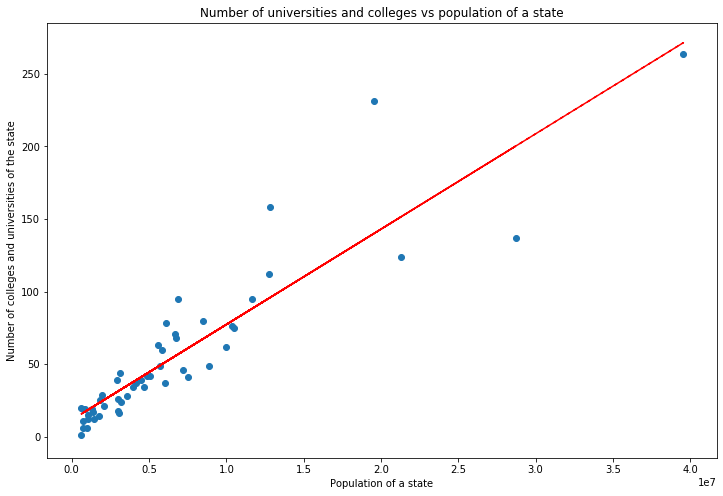

In [35]:
# We plot the number of universities and colleges over the population
plt.figure(figsize=(12,8))
plt.title("Number of universities and colleges vs population of a state")
plt.xlabel("Population of a state")
plt.ylabel("Number of colleges and universities of the state")
z = np.polyfit(df_education.Population, df_education.N_of_colleges_universities, 1)
p = np.poly1d(z)
plt.plot(df_education.Population,p(df_education.Population),"r--")
plt.scatter(df_education.Population, df_education.N_of_colleges_universities) 
plt.savefig("plots/plots_university_vs_population.jpg", dpi=150)

In [36]:
plot_plotly_scatter(
    df_education.Population,
    df_education.High_School_Fee,
    df_education.State,
    "High school fees vs population of a state",
    "plots/high_school_fees_vs_population.html",
    "Population",
    "Average High School Fee ($)"
)

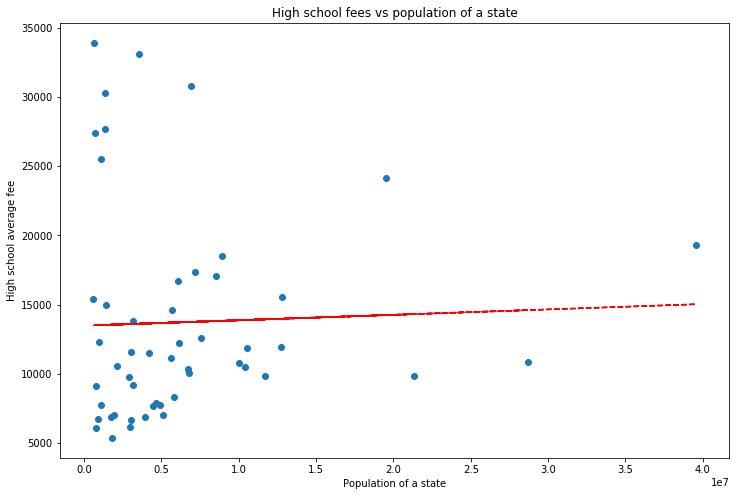

In [37]:
# We do the same for the High school fees
plt.figure(figsize=(12,8))
plt.title("High school fees vs population of a state")
plt.xlabel("Population of a state")
plt.ylabel("High school average fee")
z = np.polyfit(df_education.Population, df_education.High_School_Fee, 1)
p = np.poly1d(z)
plt.plot(df_education.Population,p(df_education.Population),"r--")
plt.scatter(df_education.Population, df_education.High_School_Fee) 
plt.savefig("plots/plots_university_fee_vs_population.jpg", dpi=150)

We can see that in the first case we can see a clear correlation between the two quantities, while in the second case there isn't.
We can consider as clearly extensive the first three features we have considered (Number of colleges and universities, Number of junior colleges, Number of professional schools).
But what about the top-230-ranking score?
Of course, it is influenced by the total number of universities: if there are more universities, it is more likely that many will be in the top 230. But the score is not barely related to the number of universities present in the ranking: will we find a meaningful correlation?
Let's plot this index in function of the population!

In [38]:
plot_plotly_scatter(
    df_education.Population,
    df_education.top_230_ranking_score,
    df_education.State,
    "Top-230-ranking score vs population of a state",
    "plots/top_230_vs_population.html",
    "Population",
    "Top-230 score of universities"
)

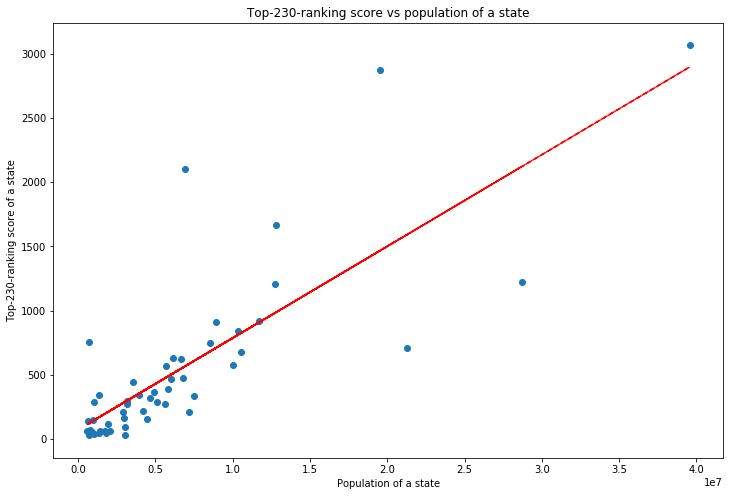

In [39]:
# We plot the top-230-ranking scorse vs the population
plt.figure(figsize=(12,8))
plt.title("Top-230-ranking score vs population of a state")
plt.xlabel("Population of a state")
plt.ylabel("Top-230-ranking score of a state")
z = np.polyfit(df_education.Population, df_education.top_230_ranking_score, 1)
p = np.poly1d(z)
plt.plot(df_education.Population,p(df_education.Population),"r--")
plt.scatter(df_education.Population, df_education.top_230_ranking_score) 
plt.savefig("plots/top_230_university_vs_population.jpg", dpi=150)

The relation seems to be meaningful! We can consider this quantity as extensive, and therefore we need to normalize it in function of the population!
Let's normalize our quantities!

In [40]:
# We calculate the normalized quantities we need
df_education_norm = df_education.copy()
df_education_norm['Colleges_universities_per_1000000'] = (df_education.N_of_colleges_universities)/(df_education.Population)*1000000
df_education_norm['Junior_colleges_per_1000000'] = (df_education.N_of_junior_colleges)/(df_education.Population)*1000000
df_education_norm['Prof_schools_per_1000000'] = (df_education.N_of_technical_trade_schools)/(df_education.Population)*1000000
df_education_norm['Intensive_top_230_score'] = (df_education.top_230_ranking_score)/(df_education.Population)*1000000
df_education_norm.head()

State  Population  N_of_colleges_universities  N_of_junior_colleges  \
0     alabama   4887871.0                        42.0                  36.0   
1      alaska    737438.0                         6.0                   1.0   
2     arizona   7171646.0                        46.0                  43.0   
3    arkansas   3013825.0                        26.0                  26.0   
4  california  39557045.0                       264.0                 191.0   

   N_of_technical_trade_schools  awards_per_value  exp_award_value  \
0                          16.0         19.514493     63013.173913   
1                           2.0         18.414286    141431.142857   
2                          42.0         25.563492     47830.888889   
3                          32.0         21.970833     51132.479167   
4                         239.0         22.771429     63022.202857   

   top_230_ranking_score  High_School_Fee  Elementary_School_Fee  \
0                    366             7718                   6388   
1                     29             6118                   7544   
2                    209            17339                   6283   
3                     96             6680                   4698   
4                   3064            19317                  11363   

   Colleges_universities_per_1000000  Junior_colleges_per_1000000  \
0                           8.592698                     7.365170   
1                           8.136277                     1.356046   
2                           6.414148                     5.995834   
3                           8.626911                     8.626911   
4                           6.673906                     4.828470   

   Prof_schools_per_1000000  Intensive_top_230_score  
0                  3.273409                74.879227  
1                  2.712092                39.325340  
2                  5.856396                29.142543  
3                 10.617737                31.853210  
4                  6.041907                77.457758

In [41]:
# Now we keep only the intensive quantities we need
df_education_final = df_education_norm[['State', 'awards_per_value', 'exp_award_value', 'High_School_Fee', 
                                        'Elementary_School_Fee', 'Colleges_universities_per_1000000', 
                                        'Junior_colleges_per_1000000', 
                                        'Prof_schools_per_1000000', 'Intensive_top_230_score']]
df_education_final.head()

State  awards_per_value  exp_award_value  High_School_Fee  \
0     alabama         19.514493     63013.173913             7718   
1      alaska         18.414286    141431.142857             6118   
2     arizona         25.563492     47830.888889            17339   
3    arkansas         21.970833     51132.479167             6680   
4  california         22.771429     63022.202857            19317   

   Elementary_School_Fee  Colleges_universities_per_1000000  \
0                   6388                           8.592698   
1                   7544                           8.136277   
2                   6283                           6.414148   
3                   4698                           8.626911   
4                  11363                           6.673906   

   Junior_colleges_per_1000000  Prof_schools_per_1000000  \
0                     7.365170                  3.273409   
1                     1.356046                  2.712092   
2                     5.995834                  5.856396   
3                     8.626911                 10.617737   
4                     4.828470                  6.041907   

   Intensive_top_230_score  
0                74.879227  
1                39.325340  
2                29.142543  
3                31.853210  
4                77.457758

We have created now some new intensive features that are of course more useful! 
- *Colleges and universities per 1 million inhabitants*: it mantains a positive meaning, more schools are there per million inhabitants, the more the education system is efficient!
- *Junior colleges per 1 million inhabitants*: same as before!
- *Professional schools per 1 million inhabitants*: same as before!
- *Intensive top-230-ranking score*: calculated dividing the previous score by the number of inhabitants and multiplying the obtained number per 1000000, in order to have a decent value of score for each state.

Now we have some **positive** features:
- *Number of graduations per 100 students*;
- *Institutional expenditure per graduation*;
- *Intensive top-230-ranking score*
- *Colleges and universities per 1 million inhabitants*;
- *Junior colleges per 1 million inhabitants*;
- *Professional schools per 1 million inhabitants*.

Let's see if normalizing these features and plotting them, we obtain a sort of common trend!

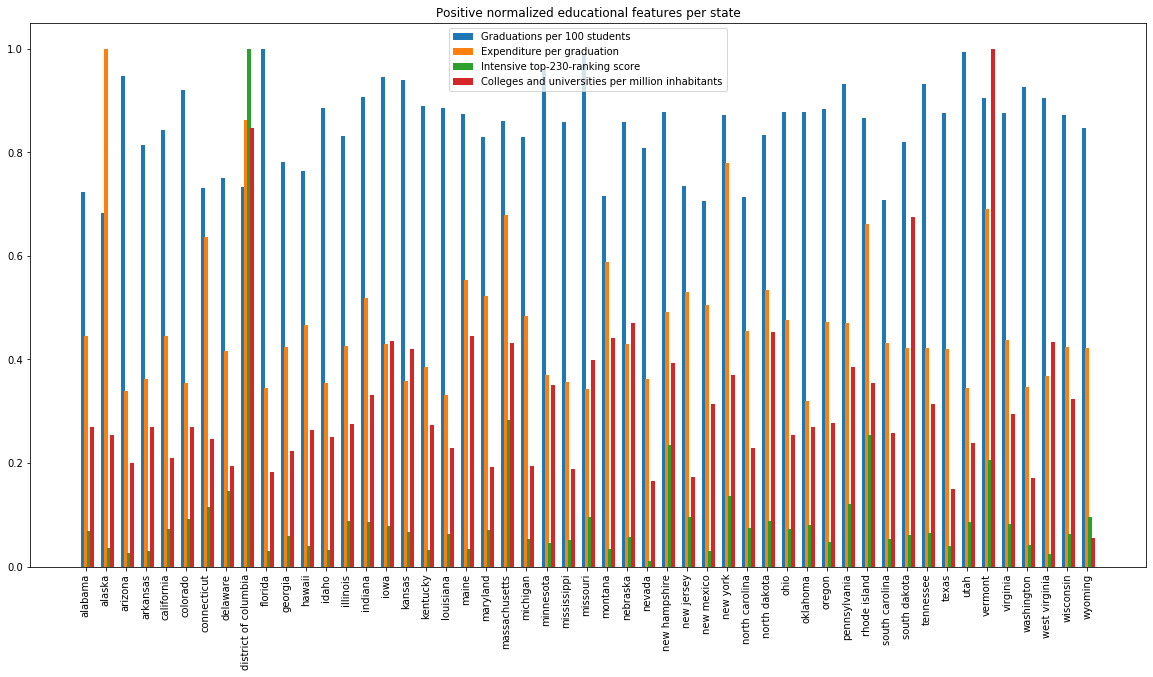

In [42]:
# We plot the positive obtained
plt.figure(figsize=(20,10))
plt.title("Positive normalized educational features per state")
barWidth = 0.15
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
plt.bar(r1, (df_education_final.awards_per_value)/(df_education_final.awards_per_value.max()), width=0.20) 
plt.bar(r2, (df_education_final.exp_award_value)/(df_education_final.exp_award_value.max()), width=0.20) 
plt.bar(r3, (df_education_final.Intensive_top_230_score)/(df_education_final.Intensive_top_230_score.max()), width=0.20)
plt.bar(r4,(df_education_final.Colleges_universities_per_1000000)/(df_education_final.Colleges_universities_per_1000000.max()), width=0.20)
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('Graduations per 100 students', 'Expenditure per graduation',
                  'Intensive top-230-ranking score', 'Colleges and universities per million inhabitants'))

plt.savefig('plots/positive_education_features_per_state.jpg', dpi=200)
plt.show()

We can notice District of Columbia is the absolute champion (except for junior colleges, there is none in D.C.)! But we can see other states have good results in all categories (Massachussets, New York, Vermont, Rhode Island, West Virginia...)!
In spite of this, in general we cannot see a common trend, and in many cases we can notice that the number of junior colleges per million inhabitants seems to be a negative feature!

What about the negative features? We have now 2 negative features:
- *High school average fee*;
- *Elementary school average fee*.

Let's plot these negative features!

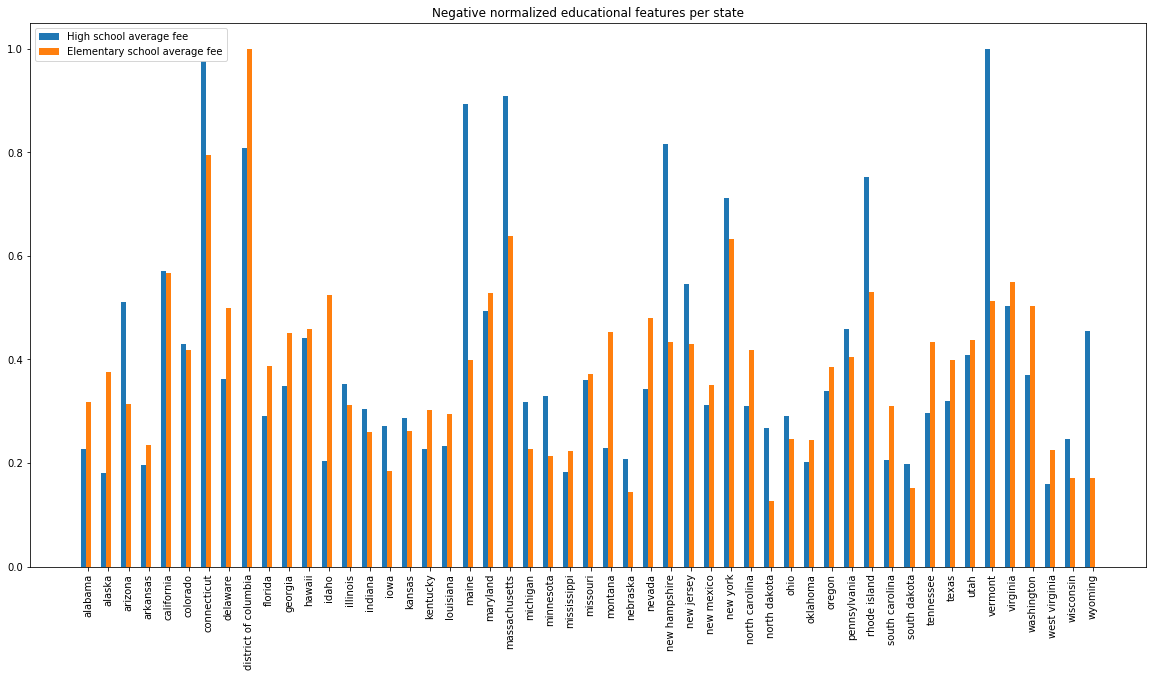

In [43]:
# We plot the negative obtained
plt.figure(figsize=(20,10))
plt.title("Negative normalized educational features per state")
barWidth = 0.25
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
plt.bar(r1, (df_education_final.High_School_Fee)/(df_education_final.High_School_Fee.max()), width=0.25) 
plt.bar(r2, (df_education_final.Elementary_School_Fee)/(df_education_final.Elementary_School_Fee.max()), width=0.25) 
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('High school average fee', 'Elementary school average fee'))
plt.savefig("plots/negative_features_education_per_state.jpg", dpi=200)
plt.show()

In this case we can see a more common trend, but some states that were excellent considering the positive features have also high negative features (for instance, District of Columbia, Massachussets, Vermont).
As said, these two parameters are of course "ambiguous", as we can consider them with a negative and a positive meaning, but we are still convinced a good education is an education with excellent references, but also that is affordable to everyone!
That is why these two features are considered as negative, even if in general they are positively correlated with a good level of education!

In [44]:
df_education_final.corr()

awards_per_value  exp_award_value  \
awards_per_value                           1.000000        -0.462936   
exp_award_value                           -0.462936         1.000000   
High_School_Fee                           -0.003290         0.514762   
Elementary_School_Fee                     -0.238315         0.510086   
Colleges_universities_per_1000000          0.045259         0.425445   
Junior_colleges_per_1000000                0.119337        -0.399632   
Prof_schools_per_1000000                   0.273877        -0.220738   
Intensive_top_230_score                   -0.157402         0.520052   

                                   High_School_Fee  Elementary_School_Fee  \
awards_per_value                         -0.003290              -0.238315   
exp_award_value                           0.514762               0.510086   
High_School_Fee                           1.000000               0.680079   
Elementary_School_Fee                     0.680079               1.000000   
Colleges_universities_per_1000000         0.366335               0.180728   
Junior_colleges_per_1000000              -0.291071              -0.577621   
Prof_schools_per_1000000                 -0.082372              -0.079954   
Intensive_top_230_score                   0.504074               0.612066   

                                   Colleges_universities_per_1000000  \
awards_per_value                                            0.045259   
exp_award_value                                             0.425445   
High_School_Fee                                             0.366335   
Elementary_School_Fee                                       0.180728   
Colleges_universities_per_1000000                           1.000000   
Junior_colleges_per_1000000                                -0.082591   
Prof_schools_per_1000000                                   -0.028795   
Intensive_top_230_score                                     0.546815   

                                   Junior_colleges_per_1000000  \
awards_per_value                                      0.119337   
exp_award_value                                      -0.399632   
High_School_Fee                                      -0.291071   
Elementary_School_Fee                                -0.577621   
Colleges_universities_per_1000000                    -0.082591   
Junior_colleges_per_1000000                           1.000000   
Prof_schools_per_1000000                              0.091031   
Intensive_top_230_score                              -0.372686   

                                   Prof_schools_per_1000000  \
awards_per_value                                   0.273877   
exp_award_value                                   -0.220738   
High_School_Fee                                   -0.082372   
Elementary_School_Fee                             -0.079954   
Colleges_universities_per_1000000                 -0.028795   
Junior_colleges_per_1000000                        0.091031   
Prof_schools_per_1000000                           1.000000   
Intensive_top_230_score                           -0.054237   

                                   Intensive_top_230_score  
awards_per_value                                 -0.157402  
exp_award_value                                   0.520052  
High_School_Fee                                   0.504074  
Elementary_School_Fee                             0.612066  
Colleges_universities_per_1000000                 0.546815  
Junior_colleges_per_1000000                      -0.372686  
Prof_schools_per_1000000                         -0.054237  
Intensive_top_230_score                           1.000000

In [45]:
# Add abbreviations to states:
states_abbreviations = pd.read_csv('Data/state-abbrevs.csv')
states_abbreviations['state'] = states_abbreviations['state'].apply(lambda x: x.lower())
df_education_final = df_education_final.merge(states_abbreviations, left_on='State', right_on='state')

In [46]:
# Build the map for expenditure per graduation
map_expenditure_per_graduation = build_map("maps/expenditure_per_graduation.html", df_education_final, ['abbreviation', 'exp_award_value'], 'Institutional Expenditure per graduation')
map_expenditure_per_graduation

In [47]:
# Build the map for the high school fees per country

map_high_school_fees = build_map("maps/us_map_high_school_fees.html", df_education_final, ['abbreviation', 'High_School_Fee'], 'High School Fees ($)')
map_high_school_fees

### Things we still need to do
- Implement a ML model on our normalized features to obtain an "education" score
- Once this score is calculated, generate a map showing the education score for each state

## Health

In [48]:
# We create the "health" DataFrame basing on the final DataFrame of milestone 2
df_health = df[health_list]
df_health.head()

State  Population  Life_Expectancy  mc_donalds_per_100k  \
0     alabama   4887871.0        74.813987                  5.0   
1      alaska    737438.0        78.915541                  4.2   
2     arizona   7171646.0        78.364742                  4.1   
3    arkansas   3013825.0        75.626900                  5.8   
4  california  39557045.0        80.231014                  3.3   

   adult_obesity_rate  eating_vegetables_daily  Vegetable  \
0                34.7                     27.8        1.5   
1                29.4                     18.9        1.8   
2                26.7                     20.5        1.7   
3                34.6                     28.1        1.5   
4                22.7                     18.6        1.8   

   diabetes_prevalence  alcohol_prevalence  mean_physical_activity  \
0                16.19                 6.6                   45.75   
1                11.89                 9.2                   58.70   
2                13.72                 8.1                   58.20   
3                15.23                 6.9                   48.25   
4                14.51                 8.4                   60.25   

   mean_obesity  
0         39.75  
1         35.70  
2         33.10  
3         38.25  
4         31.15

For our **Health** category we have the following features
- *Life expectancy at birth* in 2015: of course, the longer the life expectancy, the higher the level of health of each state is supposed to be;
- *Number of McDonalds shops per 100000 inhabitants* in each state: McDonalds has always been considered as the example of bad nutrition habits. Of course, this is not immediately true, a McDo a month is not that unhealty (and sometimes is a real mood booster!) but in general, more McDonalds shops mean more people eating regularly there and this is correlated with bad habits, leading to alimentary disorders;
- *Adult obesity rate*: people are generally considered obese when their body mass index (BMI), a measurement obtained by dividing a person's weight by the square of the person's height, is over 30 kg/m^2 [2]. Obesity is a severe health problem, as it is supposed to cause several problems, as diabetes, cardiovascular diseases and finally death. This problem is particularly true in a country like USA, generally considered as the evil of nutrition. It is not a case that in 2013 several medical societies, including the American Medical Association and the American Heart Association, classified obesity as a disease [2].
- *Mean obesity rate*, considering not only adults, but also children;
- *Percentage of people not eating vegetables daily*: on the opposite side od McDo, vegetables are considered as the example of good nutrition. Once again, this is not true, but in general people who eat vegetables daily tend to be more careful to what they eat!
- *Average number of vegetable portions eaten daily per person*;
- *Rate of people suffering from diabetes* per state: diabetes is closely linked to obesity and is one of the most important causes of death in Western world. This is again one of the more severe health problems in US;
- *Alcohol prevalence* in 2012: rate of people who declared to consume, on average, more than one drink per day for women or two drinks per day for men in the past 30 days. It can be related to several kinds of healthy problems and diseases;
- *Physical activity prevalence* in 2012: rate of people who is physically active daily. Physical activity is linked to a healthy lifestyle and therefore to a better life.

Let's start looking at the correlation of all of these features with the population of a state. As seen, all the collected features should be intensive features, so we do not expect a high level of correlation with the number of inhabitants.

In [49]:
pd.DataFrame(df_health.corr().Population)

Population
Population                 1.000000
Life_Expectancy            0.049108
mc_donalds_per_100k       -0.190170
adult_obesity_rate        -0.226884
eating_vegetables_daily   -0.093222
Vegetable                  0.111903
diabetes_prevalence        0.342949
alcohol_prevalence        -0.182931
mean_physical_activity    -0.008171
mean_obesity              -0.009115

In [50]:
df_health_norm = df_health.drop(columns='Population')
df_health_norm.head()

State  Life_Expectancy  mc_donalds_per_100k  adult_obesity_rate  \
0     alabama        74.813987                  5.0                34.7   
1      alaska        78.915541                  4.2                29.4   
2     arizona        78.364742                  4.1                26.7   
3    arkansas        75.626900                  5.8                34.6   
4  california        80.231014                  3.3                22.7   

   eating_vegetables_daily  Vegetable  diabetes_prevalence  \
0                     27.8        1.5                16.19   
1                     18.9        1.8                11.89   
2                     20.5        1.7                13.72   
3                     28.1        1.5                15.23   
4                     18.6        1.8                14.51   

   alcohol_prevalence  mean_physical_activity  mean_obesity  
0                 6.6                   45.75         39.75  
1                 9.2                   58.70         35.70  
2                 8.1                   58.20         33.10  
3                 6.9                   48.25         38.25  
4                 8.4                   60.25         31.15

We can split once again our features in **positive** and **negative**.

We can consider as positive:
- *Life expectancy at birth*;
- *Number of vegetable portions eaten daily per person*;
- *Physical activity prevalence*.

Instead we have as negative features:
- *Number of McDonalds shops per 100000 inhabitants*;
- *Percentage of people not eating vegetables daily*;
- *Adult obesity rate*;
- *Mean obesity rate*;
- *Diabetes prevalence*;
- *Alcohol prevalence*.

Now let's look at the correlation between our features: we should see positive features positively correlated each other but not with negative features, and vice versa.

In [101]:
# Create the heatmap for the correlation among columns
build_heatmap(df_health_norm.drop(['State'], axis=1), "Correlation among columns of the health dataset", "plots/heatmap_df_health.html")

In [52]:
df_health_norm.corr()

Life_Expectancy  mc_donalds_per_100k  \
Life_Expectancy                 1.000000            -0.603849   
mc_donalds_per_100k            -0.603849             1.000000   
adult_obesity_rate             -0.736961             0.548133   
eating_vegetables_daily        -0.571649             0.415053   
Vegetable                       0.508934            -0.386006   
diabetes_prevalence            -0.826542             0.428956   
alcohol_prevalence              0.574026            -0.199260   
mean_physical_activity          0.785877            -0.399183   
mean_obesity                   -0.752466             0.475798   

                         adult_obesity_rate  eating_vegetables_daily  \
Life_Expectancy                   -0.736961                -0.571649   
mc_donalds_per_100k                0.548133                 0.415053   
adult_obesity_rate                 1.000000                 0.766348   
eating_vegetables_daily            0.766348                 1.000000   
Vegetable                         -0.746858                -0.947860   
diabetes_prevalence                0.536810                 0.518767   
alcohol_prevalence                -0.393658                -0.354527   
mean_physical_activity            -0.806486                -0.774558   
mean_obesity                       0.942865                 0.743352   

                         Vegetable  diabetes_prevalence  alcohol_prevalence  \
Life_Expectancy           0.508934            -0.826542            0.574026   
mc_donalds_per_100k      -0.386006             0.428956           -0.199260   
adult_obesity_rate       -0.746858             0.536810           -0.393658   
eating_vegetables_daily  -0.947860             0.518767           -0.354527   
Vegetable                 1.000000            -0.436833            0.355295   
diabetes_prevalence      -0.436833             1.000000           -0.670811   
alcohol_prevalence        0.355295            -0.670811            1.000000   
mean_physical_activity    0.775138            -0.749479            0.649040   
mean_obesity             -0.720079             0.658064           -0.496215   

                         mean_physical_activity  mean_obesity  
Life_Expectancy                        0.785877     -0.752466  
mc_donalds_per_100k                   -0.399183      0.475798  
adult_obesity_rate                    -0.806486      0.942865  
eating_vegetables_daily               -0.774558      0.743352  
Vegetable                              0.775138     -0.720079  
diabetes_prevalence                   -0.749479      0.658064  
alcohol_prevalence                     0.649040     -0.496215  
mean_physical_activity                 1.000000     -0.837010  
mean_obesity                          -0.837010      1.000000

Even if there are some exceptions (surprisingly, alcohol prevalence seems to be a positive feature) in general these trends are respected!
Going further into the data, we can notice some very high correlations.

The first, obvious, is the one between people who do not eat vegetables and the number of vegetable portions consumed daily per person. Let's look more closely at this correlation.

In [53]:
plot_plotly_scatter(
    df_health_norm.Vegetable,
    df_health_norm.eating_vegetables_daily,
    df_health_norm.State,
    "People not eating vegetables daily vs portions of vegetables consumed daily",
    "plots/vegetables_daily.html",
    "Portions of vegetables consumed daily",
    "People not eating vegetables daily"
)

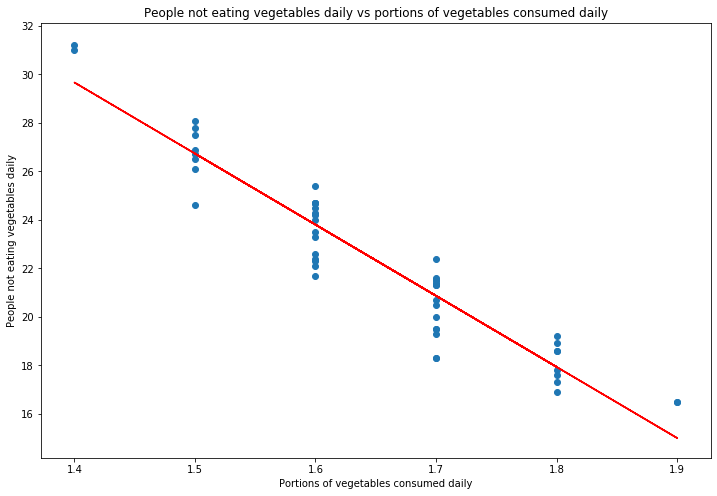

In [54]:
plt.figure(figsize=(12,8))
plt.title("People not eating vegetables daily vs portions of vegetables consumed daily")
plt.xlabel("Portions of vegetables consumed daily")
plt.ylabel("People not eating vegetables daily")
z = np.polyfit(df_health_norm.Vegetable, df_health_norm.eating_vegetables_daily, 1)
p = np.poly1d(z)
plt.plot(df_health_norm.Vegetable,p(df_health_norm.Vegetable),"r--")
plt.scatter(df_health_norm.Vegetable, df_health_norm.eating_vegetables_daily) 
plt.savefig("plots/vegetables.jpg", dpi=200)

The second strong correlation we can see is the one, still obvious, between the adult obesity rate and the mean obesity rate. This is quite obvious, but we can highlight an important trend.

In [55]:
plot_plotly_scatter(df_health_norm.adult_obesity_rate,
                    df_health_norm.mean_obesity,
                    df_health_norm.State,
                    "Mean obesity rate vs adult obesity rate",
                    "plots/adult_obesity_rate.html",
                    "Adult obesity rate",
                    "Mean obesity rate"
                   )

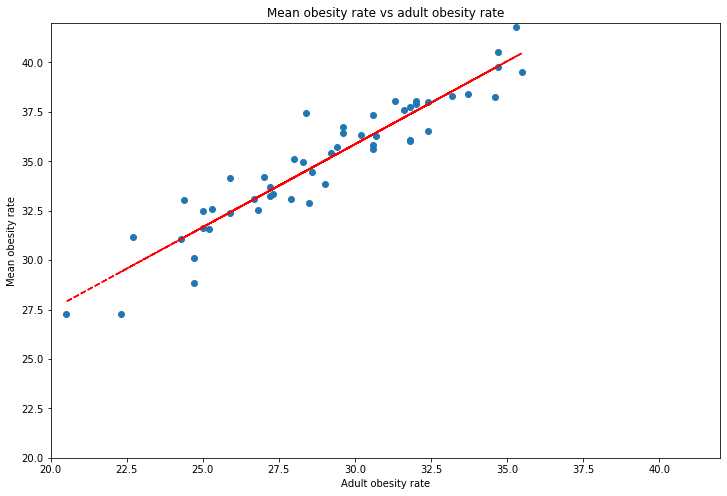

In [56]:
plt.figure(figsize=(12,8))
plt.title("Mean obesity rate vs adult obesity rate")
plt.xlabel("Adult obesity rate")
plt.ylabel("Mean obesity rate")
plt.xlim(20,42)
plt.ylim(20,42)
z = np.polyfit(df_health_norm.adult_obesity_rate, df_health_norm.mean_obesity, 1)
p = np.poly1d(z)
plt.plot(df_health_norm.adult_obesity_rate,p(df_health_norm.adult_obesity_rate),"r--")
plt.scatter(df_health_norm.adult_obesity_rate, df_health_norm.mean_obesity)
plt.savefig("plots/adult_obesity_rate.jpg", dpi=200)

We can notice mean obesity rate (involving also children and youngsters) is way higher than adult obesity rate. This is quite worrying: young people in USA tend to be fatter and less healthy than adults, and this trend absolutely needs to be reverted!
This data reveal bad habits in US tend to spread more and more and are diffused in the youngest parts of the population: this is a feature that can be observed not only in the US, but also in all Western World, and is related to many factors: sedentariety, capillar diffusion of fast food shops, less alimentary education, higher capability of obtaining food than in previous generations.

These two very strong correlations suggest us we can drop for both couples one of the two features. We decide to drop for the first couple the number of vegetables eaten, as it has more discrete values than the rate of people not eating vegetables daily, and the adult obesity rate, as the mean obesity rate is more representative and comprends also young people.

In [57]:
df_health_final = df_health_norm.drop(columns=['adult_obesity_rate', 'Vegetable'])
df_health_final.head()

State  Life_Expectancy  mc_donalds_per_100k  eating_vegetables_daily  \
0     alabama        74.813987                  5.0                     27.8   
1      alaska        78.915541                  4.2                     18.9   
2     arizona        78.364742                  4.1                     20.5   
3    arkansas        75.626900                  5.8                     28.1   
4  california        80.231014                  3.3                     18.6   

   diabetes_prevalence  alcohol_prevalence  mean_physical_activity  \
0                16.19                 6.6                   45.75   
1                11.89                 9.2                   58.70   
2                13.72                 8.1                   58.20   
3                15.23                 6.9                   48.25   
4                14.51                 8.4                   60.25   

   mean_obesity  
0         39.75  
1         35.70  
2         33.10  
3         38.25  
4         31.15

Now, as seen for the education category, let's see if we can find a coherent trend between all positive features and negative features.

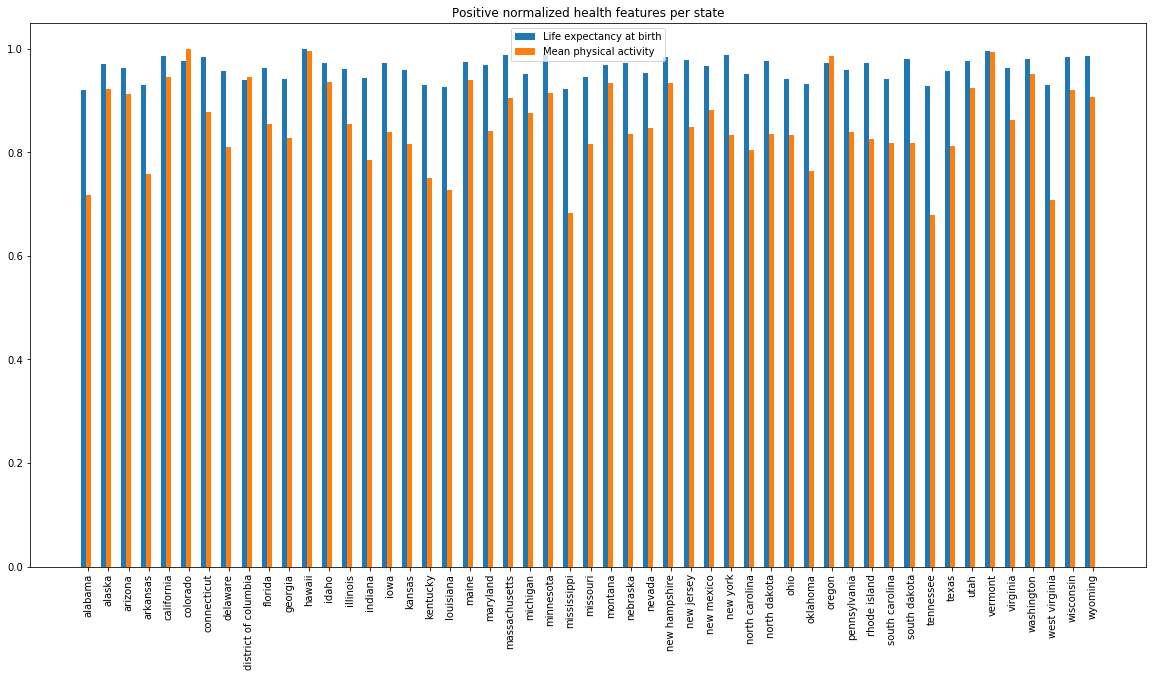

In [58]:
# We plot the positive features
plt.figure(figsize=(20,10))
plt.title("Positive normalized health features per state")
barWidth = 0.25
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
plt.bar(r1, (df_health_final.Life_Expectancy)/(df_health_final.Life_Expectancy.max()), width=0.25) 
plt.bar(r2, (df_health_final.mean_physical_activity)/(df_health_final.mean_physical_activity.max()), width=0.25) 
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('Life expectancy at birth', 'Mean physical activity'))
plt.savefig("plots/life_expectancy_vs_physical_activity.jpg", dpi=200)
plt.show()

Even if physical activity prevalence has a more variable range, we can notice a common path between the two positive features! We can see there are some really good states (California, Colorado, Oregon, Utah, Hawaii) and some really negative ones (Alabama, Arkansas, Louisiana, Mississippi, Tennessee, West Virginia).
In general, correlation between these two features still seems to be very strong, as previously seen.

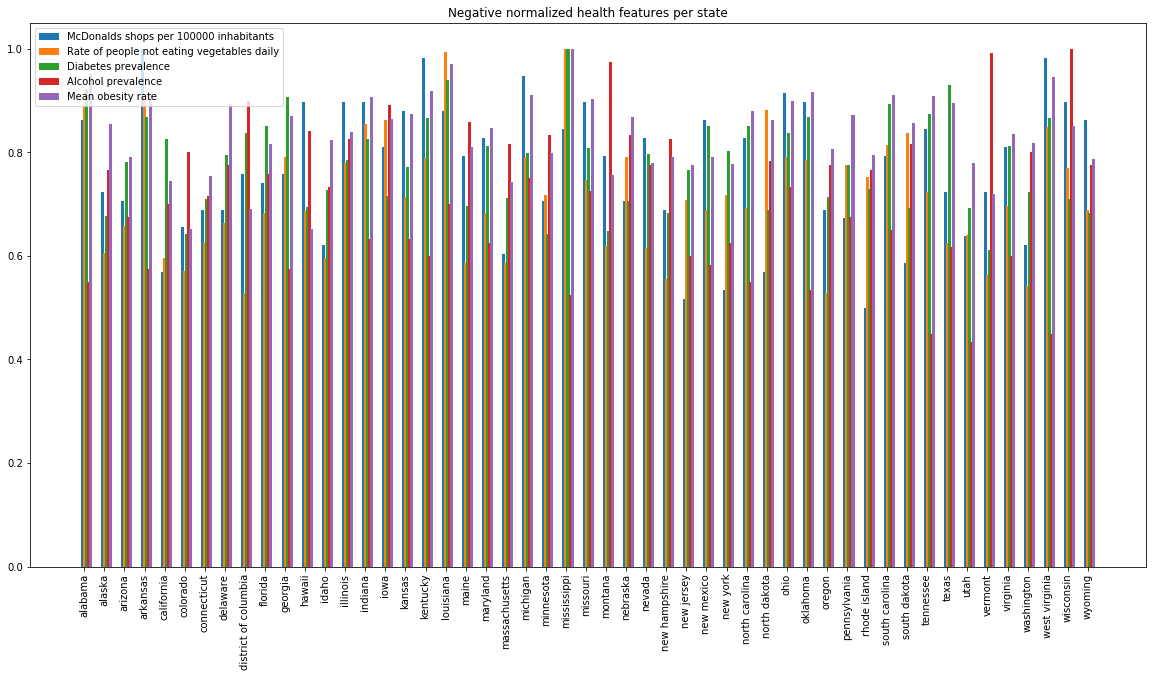

In [59]:
# We plot the negative
plt.figure(figsize=(20,10))
plt.title("Negative normalized health features per state")
barWidth = 0.10
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
plt.bar(r1, (df_health_final.mc_donalds_per_100k)/(df_health_final.mc_donalds_per_100k.max()), width=0.15) 
plt.bar(r2, (df_health_final.eating_vegetables_daily)/(df_health_final.eating_vegetables_daily.max()), width=0.15) 
plt.bar(r3, (df_health_final.diabetes_prevalence)/(df_health_final.diabetes_prevalence.max()), width=0.15)
plt.bar(r4, (df_health_final.alcohol_prevalence)/(df_health_final.alcohol_prevalence.max()), width=0.15)
plt.bar(r5, (df_health_final.mean_obesity)/(df_health_final.mean_obesity.max()), width=0.15)
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('McDonalds shops per 100000 inhabitants', 'Rate of people not eating vegetables daily',
                  'Diabetes prevalence', 'Alcohol prevalence',
                  'Mean obesity rate'))
plt.savefig("plots/negative_health_features.jpg", dpi=200)
plt.show()

In this case too, we can find a quite common pattern for negative features, except for one: alcohol prevalence (and in some cases rate of people not eating vegetables daily). But let's underline some interesting facts:
- This time the worst states for positive features confirm to be the worst, in the sense that they excell in negative features: Arkansas, Louisiana, Mississippi and West Virginia have very high values of all evaluated negative features (except, as said, alcohol prevalence);
- The same consideration can be done for the best states: California, Hawaii, Oregon, Utah, but this time also Vermont and Washington have low values of all the negative features considered;
- We can see for all features a quite homogeneous distribution except for one: alcohol prevalence! In particular, we can notice two very low values. Curiously, they concern one of the worst states, that is to say West Virginia, and one of the best ones, that is Utah!

Regarding Utah, we can see it is a mainly mormon state (60% of the 88% of christians) [3]. Mormons follow the *Word of Wisdom* revealed by God to Joseph Smith in 1833 [4], that prohibits wine and other alcoholic drinks, hot drinks like tea or coffee and drugs. Due to this healthy revealed lifestyle, we will expect a very high health score for Utah!

Regarding West Virginia, these data are quite strange. As said, it do not seems to be a very healthy state, it does not have any severe regulation for alcohol consumption, nor some religious concerns as Utah. 

In general, we need to consider that our data about alcohol prevalence refer to very "easy to obtain" parameters: it is probable that many people drink alcoholic beverages also once a week, and these people enter in our considered part of the population, considering how the data about alcohol prevalence are evaluated.

### Things we still need to do
- Implement a ML model on our normalized features to obtain an "health" score
- Once this score is calculated, generate a map showing the health score for each state

## Security

In [60]:
# We create the "security" DataFrame basing on the final DataFrame of milestone 2
df_security = df[security_list]
df_security.head()

State  Population  alcohol_prevalence  Overall Homeless, 2018  \
0     alabama   4887871.0                 6.6                    3434   
1      alaska    737438.0                 9.2                    2016   
2     arizona   7171646.0                 8.1                    9865   
3    arkansas   3013825.0                 6.9                    2712   
4  california  39557045.0                 8.4                  129972   

   Violent_Crime  Murder_and_Manslaughter   Rape  Robbery  Aggravated_Assoult  \
0          532.3                      8.4   39.4     96.4               388.2   
1          804.2                      7.0  141.9    114.6               540.6   
2          470.1                      5.5   47.5    101.8               315.4   
3          550.9                      7.2   71.7     70.9               401.0   
4          445.3                      4.9   34.9    139.6               265.9   

   Property_crime  Burglary   Theft  Motor_Vehicle_theft  
0          2947.8     700.5  2006.3                241.1  
1          3353.0     546.3  2394.7                412.1  
2          2978.4     544.4  2168.1                265.8  
3          3268.6     795.5  2233.6                239.4  
4          2553.0     479.8  1623.0                450.3

In our **Security** dataframe we have data referring to the following categories:
- *Alcohol prevalence* as seen in our Health section: we can speculate alcohol prevalence is linked to an higher rate of crimes or violent acts, and has therefore a general negative meaning concerning the security of a place;
- *Number of homeless people* in 2018 in each state: this data is linked to different factors, not least the environmental and economic ones, but in general in the common ideas a high number of homeless corresponds to a general feeling of unsecurity; we should evaluate whether this idea is supported by an actual correlation with crimes, but we can still consider this parameter as negative, as we intend as security also the *feeling of security* everybody can perceive;
- *Rate of violent crimes, murders and manslaughters, rapes, robberies, aggravated assoults, porperty crimes, burglaries, thefts and motor vehicle thefts* per 100000 inhabitants in each state, referring to 2016: all these parameters are of course correlated with the intrinsic security of a state in a very negative way; in spite of this, we could speculate some crimes are more negative than others. Our model will have differential weights depending on the kind of crime we are evaluating.

In general, all data we have collected in this category negatively describe the "security attitude" of a state. States who "excell" on these features will have a very low security score!

First of all, we notice we have all intensive data, except for one category: the **number of homeless people**. Let's evaluate if we can effectively notice a correlation between this parameter and the population.

In [61]:
df_security.columns = ['State', 'Population', 'alcohol_prevalence', 'Overall_Homeless_2018',
       'Violent_Crime', 'Murder_and_Manslaughter', 'Rape', 'Robbery',
       'Aggravated_Assoult', 'Property_crime', 'Burglary', 'Theft',
       'Motor_Vehicle_theft']

In [62]:
plot_plotly_scatter(df_security.Population, df_security.Overall_Homeless_2018,
                    df_security.State, "Number of homeless people vs population in each state",
                    "plots/homeless_vs_population.html", "Population", "number of homeless people")

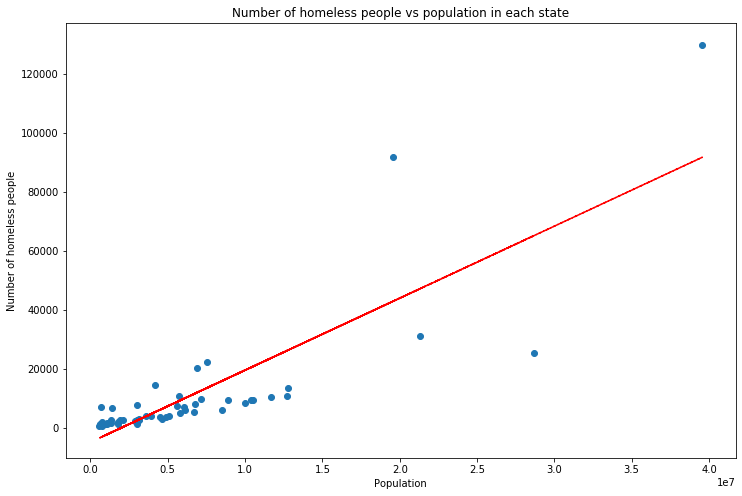

In [63]:
plt.figure(figsize=(12,8))
plt.title("Number of homeless people vs population in each state")
plt.xlabel("Population")
plt.ylabel("Number of homeless people")
z = np.polyfit(df_security.Population, df_security.Overall_Homeless_2018, 1)
p = np.poly1d(z)
plt.plot(df_security.Population,p(df_security.Population),"r--")
plt.scatter(df_security.Population, df_security.Overall_Homeless_2018) 
plt.savefig("plots/homeless_vs_population.jpg", )

We need to normalize this parameter! We will evaluate the rate of homeless people per 100000 inhabitants in each state!

In [64]:
# We calculate the normalized quantity we need
df_security_norm = df_security.copy()
df_security_norm['Homeless_per_100000'] = (df_security.Overall_Homeless_2018)/(df_security.Population)*100000
df_security_norm.head()

State  Population  alcohol_prevalence  Overall_Homeless_2018  \
0     alabama   4887871.0                 6.6                   3434   
1      alaska    737438.0                 9.2                   2016   
2     arizona   7171646.0                 8.1                   9865   
3    arkansas   3013825.0                 6.9                   2712   
4  california  39557045.0                 8.4                 129972   

   Violent_Crime  Murder_and_Manslaughter   Rape  Robbery  Aggravated_Assoult  \
0          532.3                      8.4   39.4     96.4               388.2   
1          804.2                      7.0  141.9    114.6               540.6   
2          470.1                      5.5   47.5    101.8               315.4   
3          550.9                      7.2   71.7     70.9               401.0   
4          445.3                      4.9   34.9    139.6               265.9   

   Property_crime  Burglary   Theft  Motor_Vehicle_theft  Homeless_per_100000  
0          2947.8     700.5  2006.3                241.1            70.255537  
1          3353.0     546.3  2394.7                412.1           273.378915  
2          2978.4     544.4  2168.1                265.8           137.555590  
3          3268.6     795.5  2233.6                239.4            89.985318  
4          2553.0     479.8  1623.0                450.3           328.568527

In [65]:
# Now we keep only the intensive quantities we need
df_security_final = df_security_norm[['State', 'alcohol_prevalence', 'Homeless_per_100000',
       'Violent_Crime', 'Murder_and_Manslaughter', 'Rape', 'Robbery',
       'Aggravated_Assoult', 'Property_crime', 'Burglary', 'Theft',
       'Motor_Vehicle_theft']]
df_security_final.head()

State  alcohol_prevalence  Homeless_per_100000  Violent_Crime  \
0     alabama                 6.6            70.255537          532.3   
1      alaska                 9.2           273.378915          804.2   
2     arizona                 8.1           137.555590          470.1   
3    arkansas                 6.9            89.985318          550.9   
4  california                 8.4           328.568527          445.3   

   Murder_and_Manslaughter   Rape  Robbery  Aggravated_Assoult  \
0                      8.4   39.4     96.4               388.2   
1                      7.0  141.9    114.6               540.6   
2                      5.5   47.5    101.8               315.4   
3                      7.2   71.7     70.9               401.0   
4                      4.9   34.9    139.6               265.9   

   Property_crime  Burglary   Theft  Motor_Vehicle_theft  
0          2947.8     700.5  2006.3                241.1  
1          3353.0     546.3  2394.7                412.1  
2          2978.4     544.4  2168.1                265.8  
3          3268.6     795.5  2233.6                239.4  
4          2553.0     479.8  1623.0                450.3

Now let's evaluate some correlations.
In particular, as said, alcohol prevalence and homeless people rate are the two features of our dataframe that do not refer directly to crimes and therefore to a direct concept of unsecurity, but give more a sense of unsecurity; we need to evaluate and analyze our data to determine if the general ideas of alcoholist and homeless people as violent is confirmed.
Let's evaluate this correlation.

In [108]:


rows = df_security_final.drop(['State', 'state','abbreviation'], axis=1).columns
columns = ['alcohol_prevalence', 'Homeless_per_100000']

z = df_security_final.corr()[['alcohol_prevalence', 'Homeless_per_100000']]

fig = go.Figure(data=go.Heatmap(
        z=z,
        x=columns,
        y=rows,
        colorscale='Viridis'))

fig.update_layout(
    title="correlation among alchool prevalence and homeless people, and other crimes")

fig.show()
plotly.io.write_html(fig, "plots/heatmap_alchool_prevalence_homeless.html")

Once again, alcohol does not seem to have a negative meaning, as evaluated yet in our health analysis; it's strange to say, but in general alcohol prevalence has low correlation, or even negative correlation, with the most general crimes.

We can find instead meaningful correlations between the rate of homeless people and crimes; in general, but particularly concerning **robberies**. This correlation can be quite easily explained in causal terms: in fact, homeless people, who live in poverty and basically relying on alms and charity, could be pushed by the necessity of eating and survive to commit robberies or thefts. Let's look more closely to this aspect.

In [67]:
plot_plotly_scatter(
    x=df_security_final.Homeless_per_100000,
    y=df_security_final.Robbery,
    marker=df_security_final.State,
    title="Robberies vs rate of homeless people in each state",
    output_file="plots/homeless_vs_robbery_plotly.html",
    xlabel="Rate of homeless people per 100000 inhabitants",
    ylabel="Rate of robberies per 100000 inhabitants")

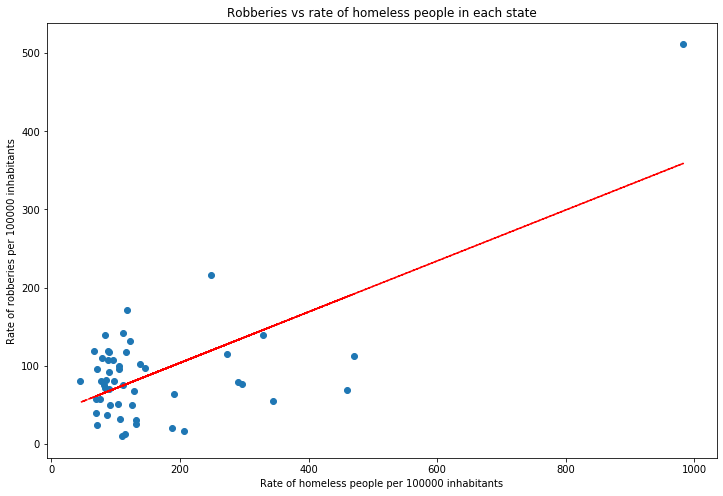

In [68]:
plt.figure(figsize=(12,8))
plt.title("Robberies vs rate of homeless people in each state")
plt.xlabel("Rate of homeless people per 100000 inhabitants")
plt.ylabel("Rate of robberies per 100000 inhabitants")
z = np.polyfit(df_security_final.Homeless_per_100000, df_security_final.Robbery, 1)
p = np.poly1d(z)
plt.plot(df_security_final.Homeless_per_100000,p(df_security_final.Homeless_per_100000),"r--")
plt.scatter(df_security_final.Homeless_per_100000, df_security_final.Robbery) 
plt.savefig("plots/homeless_vs_robbery.jpg")

We can notice in particular one state that has a very high value for both rates: let's see which state it is.

In [69]:
df_security_final.sort_values(['Homeless_per_100000'], ascending=False).head(2)

State  alcohol_prevalence  Homeless_per_100000  \
8   district of columbia                10.8           982.838758   
32              new york                 7.5           470.248783   

    Violent_Crime  Murder_and_Manslaughter  Rape  Robbery  Aggravated_Assoult  \
8          1205.9                     20.4  78.1    510.9               596.5   
32          376.2                      3.2  31.7    113.0               228.3   

    Property_crime  Burglary   Theft  Motor_Vehicle_theft  
8           4802.9     346.6  4019.8                436.5  
32          1545.6     201.7  1271.0                 72.9

We can see District of Columbia seems to be by far the worst state in terms of security; if we compare it with the second state in terms of homeless people (New York) we can see that for each feature, D.C. has much higher values!
How can this be explained?
- District of Columbia coincides with the city of Washington D.C. and in general criminality is more diffused in big cities rather than in rural areas! That is why it obtains such high rates of crimes!

Now let's look at the correlations between the different kind of crimes. Is it possible to talk of diffused criminality, or are all crimes *statistically independent* between them?
Let's look at it!

In [100]:
build_heatmap(df=df_security_final[['Violent_Crime', 'Murder_and_Manslaughter', 'Rape',
                                        'Robbery', 'Aggravated_Assoult', 'Property_crime',
                                        'Burglary', 'Theft', 'Motor_Vehicle_theft']],
             title="Correlation among different kind of crimes",
             output_filename="plots/heatmap_crimes.html")

In [70]:
df_security_crimes = df_security_final[['Violent_Crime', 'Murder_and_Manslaughter', 'Rape',
                                        'Robbery', 'Aggravated_Assoult', 'Property_crime',
                                        'Burglary', 'Theft', 'Motor_Vehicle_theft']]
print(df_security_crimes.corr().to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Violent_Crime</th>
      <th>Murder_and_Manslaughter</th>
      <th>Rape</th>
      <th>Robbery</th>
      <th>Aggravated_Assoult</th>
      <th>Property_crime</th>
      <th>Burglary</th>
      <th>Theft</th>
      <th>Motor_Vehicle_theft</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Violent_Crime</th>
      <td>1.000000</td>
      <td>0.827674</td>
      <td>0.592081</td>
      <td>0.817911</td>
      <td>0.947515</td>
      <td>0.730709</td>
      <td>0.402822</td>
      <td>0.728716</td>
      <td>0.584927</td>
    </tr>
    <tr>
      <th>Murder_and_Manslaughter</th>
      <td>0.827674</td>
      <td>1.000000</td>
      <td>0.293746</td>
      <td>0.837320</td>
      <td>0.706884</td>
      <td>0.655447</td>
      <td>0.406297</td>
      <td>0.681140</td>
      <td>0.342179</td>
    </tr>
    <tr>
      <th>Rape</th>
      <td>0.592081</td>
      <td>0.293746</td>


We can notice a quite high correlation between all crimes, even though there are some exceptions. So, we can talk about a sort of **diffused criminality** present in some areas rather than others.
How can we detect which areas are more affected by criminality?
- In general, within cities, crime rates are higher than the average [5]. This finds a quite meaningful confirmation in our data,as the only "fully metropolitan" "state", that is to say D.C., is a sort of "criminality champion";
- on this path, in general smaller cities, far from the biggest metropolitan areas, tend to be less affected to criminality; therefore we expect high rates of crimes from those states (California, New York, New Jersey, Florida, Texas) in which these big metropolitan areas are present;
- different factors like poverty (as seen in the case of homeless people), xenophobia and racial conflicts, and even climate or hours of light per day [6], can influence the criminality rate; we could expect a higher criminality in those states close to the borders (and especially on the southern one, like Texas, New Mexico, Arizona, California), but also in colder states like Colorado or especially Alaska, that has climate and latitude that are similar to some countries of Northern Europe (Sweden, Norway [7]) in which criminality rate is quite high.

To see if these are reflected in reality, let's plot some data!
Let's start with **violent crimes** (murders, rapes, general violent crimes) to see if our idea have a statistical confirmation.

In [71]:
# Add abbreviations to states:
df_security_final = df_security_final.merge(states_abbreviations, left_on='State', right_on='state')

In [72]:
df_security_final[['abbreviation', 'Robbery']]

abbreviation  Robbery
0            AL     96.4
1            AK    114.6
2            AZ    101.8
3            AR     70.9
4            CA    139.6
5            CO     63.7
6            CT     75.6
7            DE    142.7
8            DC    510.9
9            FL     97.9
10           GA    118.4
11           HI     69.6
12           ID     12.7
13           IL    139.3
14           IN    110.5
15           IA     36.6
16           KS     57.5
17           KY     75.9
18           LA    119.1
19           ME     20.0
20           MD    171.0
21           MA     78.8
22           MI     71.7
23           MN     67.5
24           MS     80.2
25           MO    107.8
26           MT     25.5
27           NE     49.6
28           NV    215.6
29           NH     32.0
30           NJ    100.4
31           NM    131.5
32           NY    113.0
33           NC     92.0
34           ND     23.9
35           OH    107.8
36           OK     80.6
37           OR     55.6
38           PA     96.4
39           RI     51.1
40           SC     81.3
41           SD     31.4
42           TN    117.5
43           TX    119.6
44           UT     50.5
45           VT     17.0
46           VA     57.1
47           WA     77.5
48           WV     39.3
49           WI     81.4
50           WY     10.1

In [73]:
robbery_map = build_map("maps/us_map_robbery.html", df_security_final, ['abbreviation', 'Robbery'], 'Robbery')
robbery_map

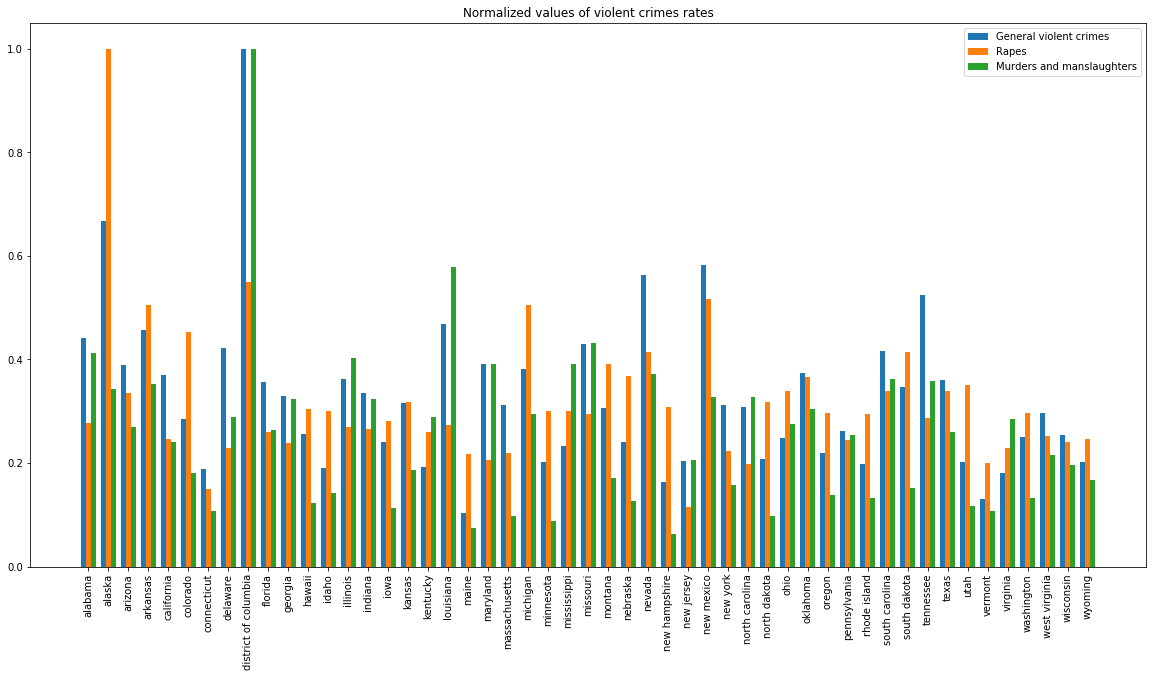

In [74]:
# We plot violent crimes
plt.figure(figsize=(20,10))
plt.title("Normalized values of violent crimes rates")
barWidth = 0.25
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, (df_security_final.Violent_Crime)/(df_security_final.Violent_Crime.max()), width=0.25) 
plt.bar(r2, (df_security_final.Rape)/(df_security_final.Rape.max()), width=0.25) 
plt.bar(r3, (df_security_final.Murder_and_Manslaughter)/(df_security_final.Murder_and_Manslaughter.max()), width=0.25)
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('General violent crimes', 'Rapes', 'Murders and manslaughters'))
plt.savefig("plots/bar_plot_crimes_rapes_murders.jpg", dpi=200)
plt.show()

As previously seen, District of Columbia is the state the most affected by violent crimes, but we can notice a particularly high value of Alaska concerning rapes (and in general regarding violent crimes); some of the states previously listed as possible "criminal" states (like New Mexico or Texas) confirm to be among the worst, but with other unsuspected ones like Louisiana, Nevada, Tennessee.
Some states have instead very low rates of violent crimes, in particular Maine, Connecticut, Idaho.

Let's consider now some **property crimes** in general and going deeper, looking for example at robbery and theft rates.

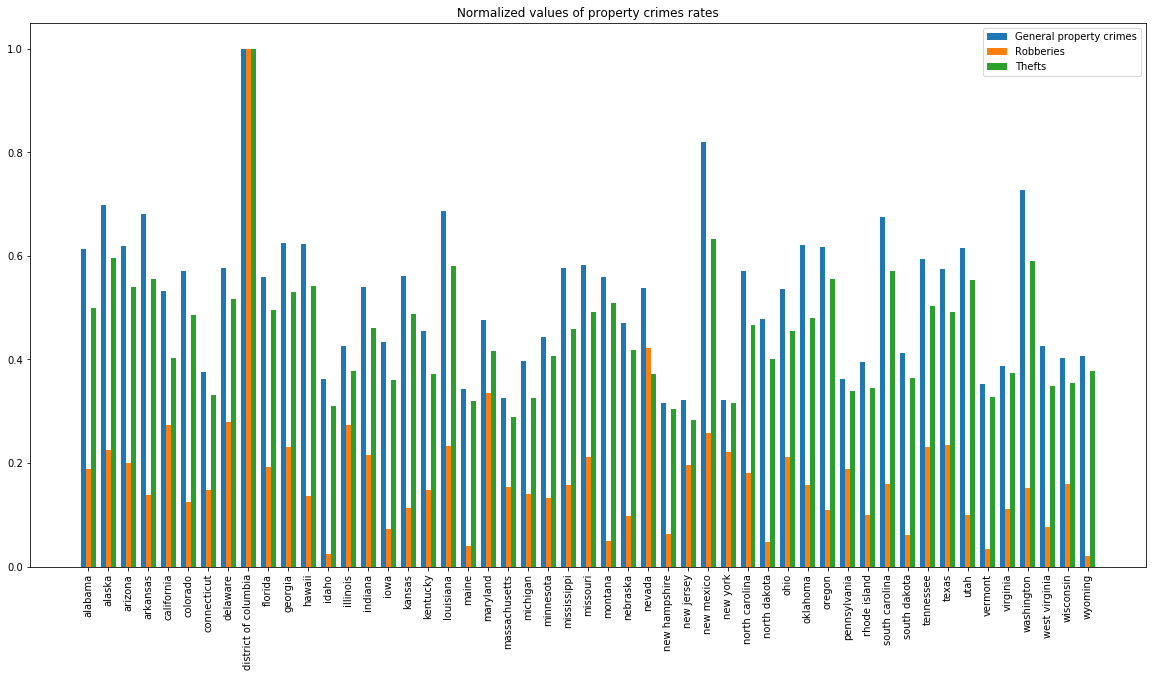

In [75]:
# We plot property crimes
plt.figure(figsize=(20,10))
plt.title("Normalized values of property crimes rates")
barWidth = 0.25
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, (df_security_final.Property_crime)/(df_security_final.Property_crime.max()), width=0.25) 
plt.bar(r2, (df_security_final.Robbery)/(df_security_final.Robbery.max()), width=0.25) 
plt.bar(r3, (df_security_final.Theft)/(df_security_final.Theft.max()), width=0.25)
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('General property crimes', 'Robberies', 'Thefts'))
plt.savefig("plots/barplot_property_crimes.jpg", dpi=200)
plt.show()

Once again, D.C., Alaska, New Mexico, but also Louisiana, Nevada, Washington, South Carolina or Hawaii have very bad rates of property crimes.
Idaho, Maine, but also North Dakota, South Dakota or Vermont have low rates of property crimes.

In general we can notice all property crimes follow a common pattern, with a couple of exceptions: the most evident one is **California**, that we had evaluated as one of the possible "criminal" states, and instead has in general very low rates about crimes, but with the exception of robberies, which rate is one of the highest in all US.

### Things we still need to do
- Implement a ML model on our normalized features to obtain a "security" score
- Once this score is calculated, generate a map showing the security score for each state

## Economy

In [76]:
# We create the "economy" DataFrame basing on the final DataFrame of milestone 2
df_economy = df[economy_list]
df_economy.head()

State  Population  Per_capita_income  mc_donalds_per_100k  \
0     alabama   4887871.0            38215.0                  5.0   
1      alaska    737438.0            54430.0                  4.2   
2     arizona   7171646.0            39955.0                  4.1   
3    arkansas   3013825.0            39171.0                  5.8   
4  california  39557045.0            54800.0                  3.3   

   Price_2018_Studio  Price_2018_1br  Price_2018_2br  Price_2018_3br  \
0         605.416667      659.000000      800.666667     1069.666667   
1         814.333333      930.500000     1190.333333     1682.166667   
2         701.000000      828.000000     1046.000000     1512.333333   
3         524.666667      571.166667      721.416667      977.583333   
4        1212.333333     1426.333333     1818.916667     2519.250000   

   Price_2018_4br  Overall Homeless, 2018  Elementary_School_Fee  \
0     1244.333333                    3434                   6388   
1     2019.500000                    2016                   7544   
2     1754.416667                    9865                   6283   
3     1144.833333                    2712                   4698   
4     2926.333333                  129972                  11363   

   High_School_Fee  
0             7718  
1             6118  
2            17339  
3             6680  
4            19317

In our **Economy** dataframe we have the following collected data:
- *Average disposable per-capita income (OECD)* in dollars, intended as the amount of money that households have available for spending and saving after income taxes have been accounted for. Disposable personal income is often monitored as one of the many key economic indicators used to gauge the overall state of the economy [8], as this value indicates the amount of money an average inhabitant of each state can use for his needs and desires. The reported values per each state refer to 2015.
We need to pay particular attention to this parameter, as we are considering the average value, but in general the distribution of disposable per-capita income is quite "right skewed", with many people attesting on a quite low value and just a few owning a very high purchasing power! It would be more useful, when describing a society, having the median of this value, but all governative and non-governative datasets for USA report the average value, so we will perform our analysis on this value.
- *Number of McDonalds shops per 100000 inhabitants* for each state: in general McDonalds in USA is cheaper than a normal restaurant, so at a theorical level we should notice a higher amount of McDos in states where the personal incomes will be lower.
- *Average rent for studios, 1-bedroom apartments, 2-bedroom apartments, 3-bedroom apartments, 4-bedroom apartments* in each state, referring to 2018: this parameter will be higher in wealthy states, as usually rents are higher in places where there is a big amount of economic activities (financial, industrial or tertiary). Thus, in general, higher prices will correspond to a general better economic situation of that state.
- *High school and Elementary school fees* that we had evaluated yet in the "Education" section: in this case, we can do the same reasoning made for rents; we need to remember that our reasoning in the "Education" section was exactly the opposite, as we wanted to consider a sort of ratio quality-price for education, while in this case we are evaluating the "absolute" wealth of each state.

In [77]:
df_economy.columns = ['State', 'Population', 'Per_capita_income', 'mc_donalds_per_100k',
       'Price_2018_Studio', 'Price_2018_1br', 'Price_2018_2br',
       'Price_2018_3br', 'Price_2018_4br', 'Overall_Homeless_2018',
       'Elementary_School_Fee', 'High_School_Fee']
df_economy.head()

State  Population  Per_capita_income  mc_donalds_per_100k  \
0     alabama   4887871.0            38215.0                  5.0   
1      alaska    737438.0            54430.0                  4.2   
2     arizona   7171646.0            39955.0                  4.1   
3    arkansas   3013825.0            39171.0                  5.8   
4  california  39557045.0            54800.0                  3.3   

   Price_2018_Studio  Price_2018_1br  Price_2018_2br  Price_2018_3br  \
0         605.416667      659.000000      800.666667     1069.666667   
1         814.333333      930.500000     1190.333333     1682.166667   
2         701.000000      828.000000     1046.000000     1512.333333   
3         524.666667      571.166667      721.416667      977.583333   
4        1212.333333     1426.333333     1818.916667     2519.250000   

   Price_2018_4br  Overall_Homeless_2018  Elementary_School_Fee  \
0     1244.333333                   3434                   6388   
1     2019.500000                   2016                   7544   
2     1754.416667                   9865                   6283   
3     1144.833333                   2712                   4698   
4     2926.333333                 129972                  11363   

   High_School_Fee  
0             7718  
1             6118  
2            17339  
3             6680  
4            19317

As in "security" section, we need to evaluate the number of homeless people without depending on the number of inhabitants. So we need to normalize our values, as done in the previous section, calculating the number of homeless people per 100000 inhabitants.

In [78]:
df_economy_norm = df_economy.drop(columns='Overall_Homeless_2018')
df_economy_norm['Homeless_per_100000'] = df_security_final.Homeless_per_100000
df_economy_norm.head()

State  Population  Per_capita_income  mc_donalds_per_100k  \
0     alabama   4887871.0            38215.0                  5.0   
1      alaska    737438.0            54430.0                  4.2   
2     arizona   7171646.0            39955.0                  4.1   
3    arkansas   3013825.0            39171.0                  5.8   
4  california  39557045.0            54800.0                  3.3   

   Price_2018_Studio  Price_2018_1br  Price_2018_2br  Price_2018_3br  \
0         605.416667      659.000000      800.666667     1069.666667   
1         814.333333      930.500000     1190.333333     1682.166667   
2         701.000000      828.000000     1046.000000     1512.333333   
3         524.666667      571.166667      721.416667      977.583333   
4        1212.333333     1426.333333     1818.916667     2519.250000   

   Price_2018_4br  Elementary_School_Fee  High_School_Fee  Homeless_per_100000  
0     1244.333333                   6388             7718            70.255537  
1     2019.500000                   7544             6118           273.378915  
2     1754.416667                   6283            17339           137.555590  
3     1144.833333                   4698             6680            89.985318  
4     2926.333333                  11363            19317           328.568527

Now in our economic dataframe we have all intensive data, so we don't need to normalize our features against the population. In spite of this, let's see if there are some correlations of our data with population!

In [79]:
print(pd.DataFrame(df_economy_norm.corr()['Population']).to_html())
pd.DataFrame(df_economy_norm.corr()['Population'])


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Population</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Population</th>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>Per_capita_income</th>
      <td>0.116460</td>
    </tr>
    <tr>
      <th>mc_donalds_per_100k</th>
      <td>-0.190170</td>
    </tr>
    <tr>
      <th>Price_2018_Studio</th>
      <td>0.320797</td>
    </tr>
    <tr>
      <th>Price_2018_1br</th>
      <td>0.349102</td>
    </tr>
    <tr>
      <th>Price_2018_2br</th>
      <td>0.357808</td>
    </tr>
    <tr>
      <th>Price_2018_3br</th>
      <td>0.353463</td>
    </tr>
    <tr>
      <th>Price_2018_4br</th>
      <td>0.342302</td>
    </tr>
    <tr>
      <th>Elementary_School_Fee</th>
      <td>0.149239</td>
    </tr>
    <tr>
      <th>High_School_Fee</th>
      <td>0.037749</td>
    </tr>
    <tr>
      <th>Homeless_per_100000</th>
      <td>0.051336</td>
    </tr>
  </tbody>
</table>


Population
Population               1.000000
Per_capita_income        0.116460
mc_donalds_per_100k     -0.190170
Price_2018_Studio        0.320797
Price_2018_1br           0.349102
Price_2018_2br           0.357808
Price_2018_3br           0.353463
Price_2018_4br           0.342302
Elementary_School_Fee    0.149239
High_School_Fee          0.037749
Homeless_per_100000      0.051336

We can find a "slight" correlation between population and rents. We can explain it in such terms: in general, the most populated states are also the most urbanized ones, and rents tend to be higher in cities rather than in rural areas. 
In general, as expected, as all data are intensive, they have nearly no correlation with population, so we can drop our "population" column and continue to perform our analysis with our features.

In [80]:
df_economy_final = df_economy_norm.drop(columns='Population')
df_economy_final.head()

State  Per_capita_income  mc_donalds_per_100k  Price_2018_Studio  \
0     alabama            38215.0                  5.0         605.416667   
1      alaska            54430.0                  4.2         814.333333   
2     arizona            39955.0                  4.1         701.000000   
3    arkansas            39171.0                  5.8         524.666667   
4  california            54800.0                  3.3        1212.333333   

   Price_2018_1br  Price_2018_2br  Price_2018_3br  Price_2018_4br  \
0      659.000000      800.666667     1069.666667     1244.333333   
1      930.500000     1190.333333     1682.166667     2019.500000   
2      828.000000     1046.000000     1512.333333     1754.416667   
3      571.166667      721.416667      977.583333     1144.833333   
4     1426.333333     1818.916667     2519.250000     2926.333333   

   Elementary_School_Fee  High_School_Fee  Homeless_per_100000  
0                   6388             7718            70.255537  
1                   7544             6118           273.378915  
2                   6283            17339           137.555590  
3                   4698             6680            89.985318  
4                  11363            19317           328.568527

Now let's consider the relationship existing between McDos and income. As previously said, we can consider McDos as a "cheaper" alternative to restaurants, so we expect there are more McDonalds shops in states where disposable income is lower: let's see if this hypothesis is confirmed by data.

In [81]:
df_economy_final = df_economy_final.merge(states_abbreviations, left_on='State', right_on='state')
df_economy_final.head()

State  Per_capita_income  mc_donalds_per_100k  Price_2018_Studio  \
0     alabama            38215.0                  5.0         605.416667   
1      alaska            54430.0                  4.2         814.333333   
2     arizona            39955.0                  4.1         701.000000   
3    arkansas            39171.0                  5.8         524.666667   
4  california            54800.0                  3.3        1212.333333   

   Price_2018_1br  Price_2018_2br  Price_2018_3br  Price_2018_4br  \
0      659.000000      800.666667     1069.666667     1244.333333   
1      930.500000     1190.333333     1682.166667     2019.500000   
2      828.000000     1046.000000     1512.333333     1754.416667   
3      571.166667      721.416667      977.583333     1144.833333   
4     1426.333333     1818.916667     2519.250000     2926.333333   

   Elementary_School_Fee  High_School_Fee  Homeless_per_100000       state  \
0                   6388             7718            70.255537     alabama   
1                   7544             6118           273.378915      alaska   
2                   6283            17339           137.555590     arizona   
3                   4698             6680            89.985318    arkansas   
4                  11363            19317           328.568527  california   

  abbreviation  
0           AL  
1           AK  
2           AZ  
3           AR  
4           CA

In [82]:
plot_plotly_scatter(x=df_economy_final.Per_capita_income,
                   y=df_economy_final.mc_donalds_per_100k,
                   marker=df_economy_final.State,
                   title="McDonalds vs disposable personal income",
                   output_file="plots/mc_donalds_vs_disposal_income_plotly.html",
                   xlabel="Disposable per-capita income",
                   ylabel='McDonalds vs disposable personal income')

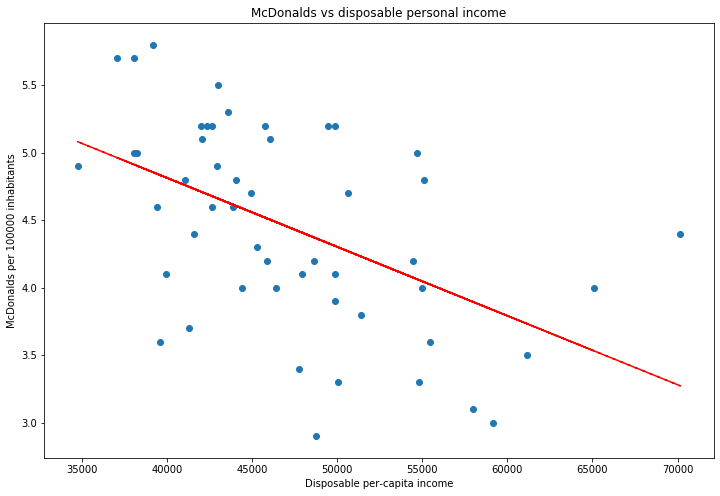

In [83]:
plt.figure(figsize=(12,8))
plt.title("McDonalds vs disposable personal income")
plt.xlabel("Disposable per-capita income")
plt.ylabel("McDonalds per 100000 inhabitants")
z = np.polyfit(df_economy_final.Per_capita_income, df_economy_final.mc_donalds_per_100k, 1)
p = np.poly1d(z)
plt.plot(df_economy_final.Per_capita_income,p(df_economy_final.Per_capita_income), "r--")
plt.scatter(df_economy_final.Per_capita_income, df_economy_final.mc_donalds_per_100k)
plt.savefig("plots/mc_donalds_vs_disposal_income.jpg", dpi=200)

We can notice a slight negative correlation between the two features, but it is not as strong as we could expect. This indicates McDonalds is more part of a general American identity, and does not depend completely on the wealth of a state: **also rich people eat at McDo from time to time!**

Now we want to explore the variation in rents when referring to houses of different size.
It could seem a not-so-meaningful analysis, but let's explain why it could be interesting!
- Starting point is that we can have a confirmation of the fact that urbanized areas as D.C., New York or California have higher rents!
- Rents, as every other field of economy, rely on the relation demand-offer. Assuming the offer is more or less the same for every kind of accomodation, higher rents should mean an higher demand for the kind of apartment!
- Now, we would expect that the trends of rents in different states should be more or less the same for each size of apartment. Theorically, states in which studio rents are higher should have higher rents also for 3-bedroom apartments.
- But we could speculate that in rural areas the idea of "big family" is more diffused than in cities; and vice versa, in big cities young people could tend to live on their own in a studio, or with their fiancé(e) in a 1-bedroom apartment!
- Following this idea, if we normalize the rents, we should see a bigger difference between big-apartments rent and studios for more "traditional" states (as, for instance, Utah) and a smaller difference in more urbanized states (as D.C. or California).

Let's see if data confirm this idea!

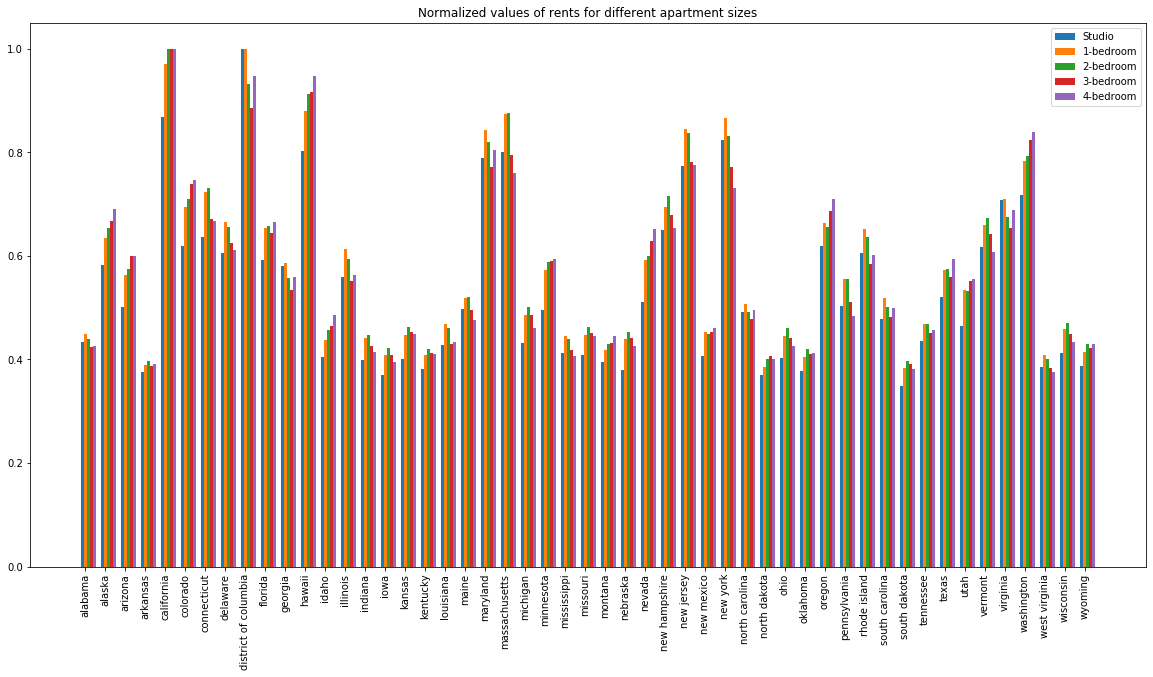

In [84]:
# We plot rents for different apartments
plt.figure(figsize=(20,10))
plt.title("Normalized values of rents for different apartment sizes")
barWidth = 0.15
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
plt.bar(r1, (df_economy_final.Price_2018_Studio)/(df_economy_final.Price_2018_Studio.max()), width=0.15) 
plt.bar(r2, (df_economy_final.Price_2018_1br)/(df_economy_final.Price_2018_1br.max()), width=0.15) 
plt.bar(r3, (df_economy_final.Price_2018_2br)/(df_economy_final.Price_2018_2br.max()), width=0.15)
plt.bar(r4, (df_economy_final.Price_2018_3br)/(df_economy_final.Price_2018_3br.max()), width=0.15)
plt.bar(r5, (df_economy_final.Price_2018_4br)/(df_economy_final.Price_2018_4br.max()), width=0.15)
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('Studio', '1-bedroom', '2-bedroom', '3-bedroom', '4-bedroom'))
plt.savefig("plots/barplot_apartment_cost.jpg")
plt.show()

In [85]:
df_economy_final_copy = df_economy_final.copy()
df_economy_final_copy['ratio_size_houses'] = (df_economy_final.Price_2018_4br)/(df_economy_final.Price_2018_Studio)
build_map("maps/us_map_ratio_4br_apartment_and_studios.html", df_economy_final_copy, ['abbreviation', 'ratio_size_houses'], 'Ratio 4 bedrooms apartments and rent/studios')

In [86]:
df_economy_final_copy[['abbreviation', 'ratio_size_houses']]

abbreviation  ratio_size_houses
0            AL           2.055334
1            AK           2.479943
2            AZ           2.502734
3            AR           2.182020
4            CA           2.413803
5            CO           2.520062
6            CT           2.200769
7            DE           2.107343
8            DC           1.982589
9            FL           2.353598
10           GA           2.014050
11           HI           2.470588
12           ID           2.517847
13           IL           2.106347
14           IN           2.172847
15           IA           2.227119
16           KS           2.349294
17           KY           2.242712
18           LA           2.114449
19           ME           2.006237
20           MD           2.134195
21           MA           1.986901
22           MI           2.234334
23           MN           2.507811
24           MS           2.067650
25           MO           2.284879
26           MT           2.357585
27           NE           2.360258
28           NV           2.670014
29           NH           2.108520
30           NJ           2.099807
31           NM           2.381722
32           NY           1.861001
33           NC           2.116697
34           ND           2.273696
35           OH           2.208155
36           OK           2.284495
37           OR           2.400154
38           PA           2.013886
39           RI           2.081643
40           SC           2.189401
41           SD           2.301748
42           TN           2.189975
43           TX           2.387064
44           UT           2.494493
45           VT           2.062736
46           VA           2.039123
47           WA           2.451924
48           WV           2.035990
49           WI           2.206048
50           WY           2.315111

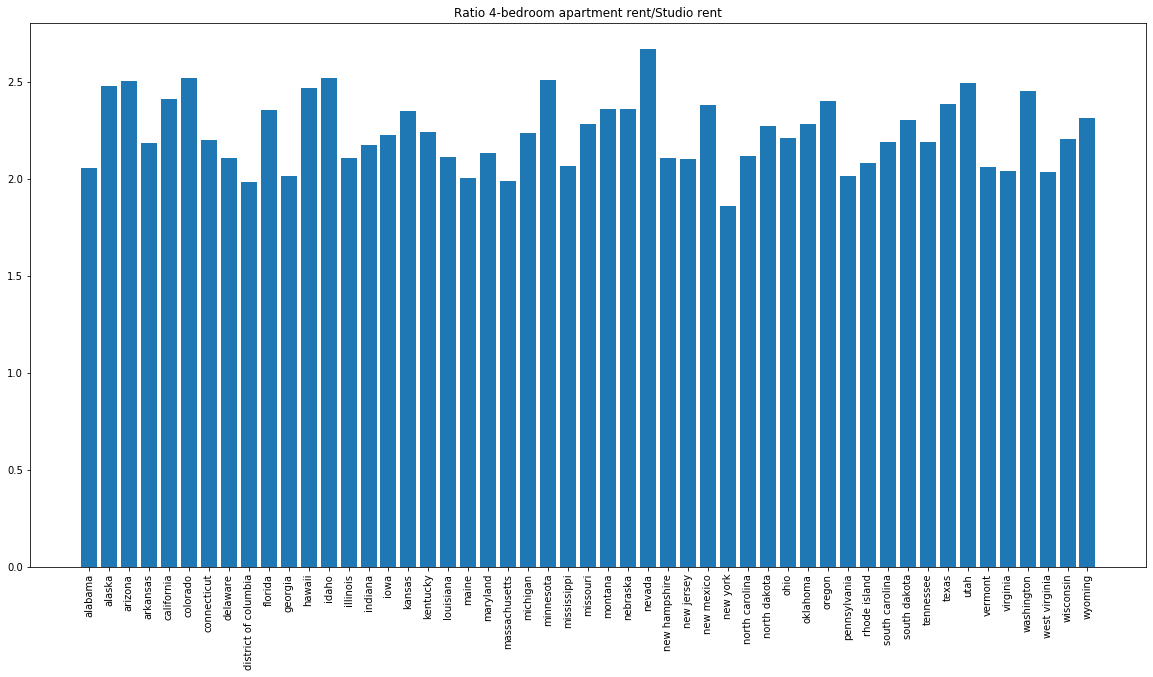

In [87]:
# We plot the ratio between 4-br rents and studio rents
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.title("Ratio 4-bedroom apartment rent/Studio rent") 
plt.bar(df_economy_final.State, 
         (df_economy_final.Price_2018_4br)/(df_economy_final.Price_2018_Studio))
plt.show()

We can say that all our ideas have a confirmation!
- In general all rents are higher in states like D.C., California, New York, New Jersey and Massachussets, that not casually are the most urbanized ones. But there is an exception: **Hawaii**. This exception "confirms the rule" and is easily explainable considering the touristic attitude of these fantastic islands!
- And in general this trend is confirmed for all kinds of accomodation! But some slight differences exist...
- Let's look at the ratio between the average rent for 4-bedroom apartments and studios. Well, our expectations are respected! There is less difference between these parameters in more urbanized states (in particular New York, but also D.C. and Massachussets), and more difference in more rural states (as Nevada, Utah, Minnesota, Idaho... and California, we cannot predict everything! In fact, in California we have the highest rents for big apartments, while in D.C. small apartments are the most expensive)

Now let's see if we can notice a correlation between school fees and income, as previously speculated.

In [88]:
# plot the graph with plotly, as it has two polyfits, we can't use the helper function.
fig = go.Figure(data=go.Scatter(x=df_economy_final.Per_capita_income,
                                y=df_economy_final.High_School_Fee,
                                mode='markers',
                                marker_color=df_economy_final.Per_capita_income,
                                text=df_economy_final.State)) # hover text goes here

polyfit1 = np.poly1d(np.polyfit(df_economy_final.Per_capita_income, df_economy_final.High_School_Fee, 1))
fig.add_shape(
        # Line Diagonal
        go.layout.Shape(
            type="line",
            x0=0,
            y0=polyfit1[0],
            x1=np.max(df_economy_final.Per_capita_income),
            y1=np.max(df_economy_final.Per_capita_income) * polyfit1[1] + polyfit1[0],
            line=dict(
                color="MediumPurple",
                width=4,
                dash="dot",
            )
))

polyfit2 = np.poly1d(np.polyfit(df_economy_final.Per_capita_income, df_economy_final.Elementary_School_Fee, 1))
fig.add_shape(
        # Line Diagonal
        go.layout.Shape(
            type="line",
            x0=0,
            y0=polyfit2[0],
            x1=np.max(df_economy_final.Per_capita_income),
            y1=np.max(df_economy_final.Per_capita_income) * polyfit2[1] + polyfit2[0],
            line=dict(
                color="Red",
                width=4,
                dash="dot",
            )
))
fig.update_layout(title="School fees vs disposable personal income",
                  xaxis_title="Disposable per-capita income",
                  yaxis_title="School fees")
plotly.io.write_html(fig, "plots/school_fees_vs_disposable_income_plotly.html")

fig.show()

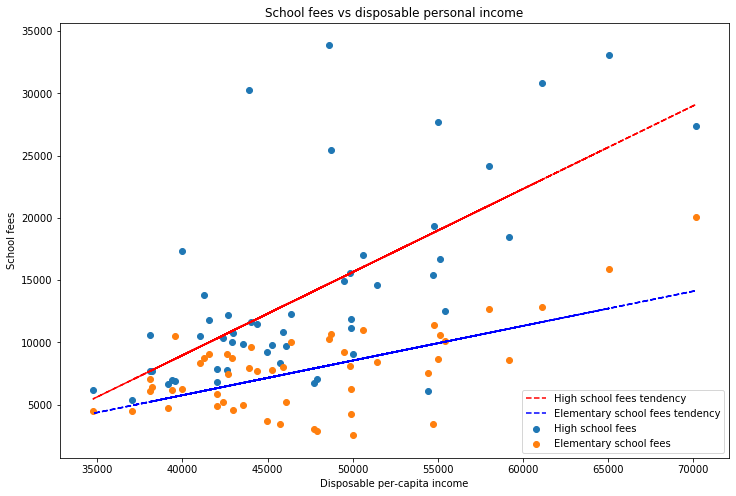

In [89]:
plt.figure(figsize=(12,8))
plt.title("School fees vs disposable personal income")
plt.xlabel("Disposable per-capita income")
plt.ylabel("School fees")
z = np.polyfit(df_economy_final.Per_capita_income, df_economy_final.High_School_Fee, 1)
p = np.poly1d(z)
plt.plot(df_economy_final.Per_capita_income,p(df_economy_final.Per_capita_income), "r--")
plt.scatter(df_economy_final.Per_capita_income, df_economy_final.High_School_Fee)
z = np.polyfit(df_economy_final.Per_capita_income, df_economy_final.Elementary_School_Fee, 1)
p = np.poly1d(z)
plt.plot(df_economy_final.Per_capita_income,p(df_economy_final.Per_capita_income), "b--")
plt.scatter(df_economy_final.Per_capita_income, df_economy_final.Elementary_School_Fee)
plt.gca().legend(('High school fees tendency', 'Elementary school fees tendency', 'High school fees', 
                  'Elementary school fees'))

plt.savefig("plots/school_fees_vs_disposable_income.jpg", dpi=200)

We can notice a quite strong correlation between personal income and school fees. This indicates a quite "fair" education system, at least regarding the economic part! But as seen in the "Education" section, in general higher fees also correspond to a better educational level, so quality of schools in USA is strongly dependent on how much money are spent on the education of children, so not everybody has the same opportunities.

In [90]:
print(df_economy_final[['High_School_Fee','Per_capita_income']].corr().to_html())
df_economy_final[['High_School_Fee','Per_capita_income']].corr()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>High_School_Fee</th>
      <th>Per_capita_income</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>High_School_Fee</th>
      <td>1.000000</td>
      <td>0.655473</td>
    </tr>
    <tr>
      <th>Per_capita_income</th>
      <td>0.655473</td>
      <td>1.000000</td>
    </tr>
  </tbody>
</table>


High_School_Fee  Per_capita_income
High_School_Fee           1.000000           0.655473
Per_capita_income         0.655473           1.000000

In [91]:
df_economy_final[['Price_2018_Studio', 'Price_2018_1br', 'Price_2018_2br',
                  'Price_2018_3br', 'Price_2018_4br']].corr()

Price_2018_Studio  Price_2018_1br  Price_2018_2br  \
Price_2018_Studio           1.000000        0.991603        0.976502   
Price_2018_1br              0.991603        1.000000        0.994290   
Price_2018_2br              0.976502        0.994290        1.000000   
Price_2018_3br              0.952433        0.975328        0.987982   
Price_2018_4br              0.948719        0.966230        0.974278   

                   Price_2018_3br  Price_2018_4br  
Price_2018_Studio        0.952433        0.948719  
Price_2018_1br           0.975328        0.966230  
Price_2018_2br           0.987982        0.974278  
Price_2018_3br           1.000000        0.992651  
Price_2018_4br           0.992651        1.000000

To conclude our analysis, let's compare the trends for income, number of McDos, rents and fees per state. We should notice a common trend for income, rents and fees, and a specular one for McDonald shops.
For clarity, we will use just 1-bedroom rents and High School Fees: our omissions are not that meaningful, as rents are all strongly correlated to each other, and so are fees in High and Elementary schools.

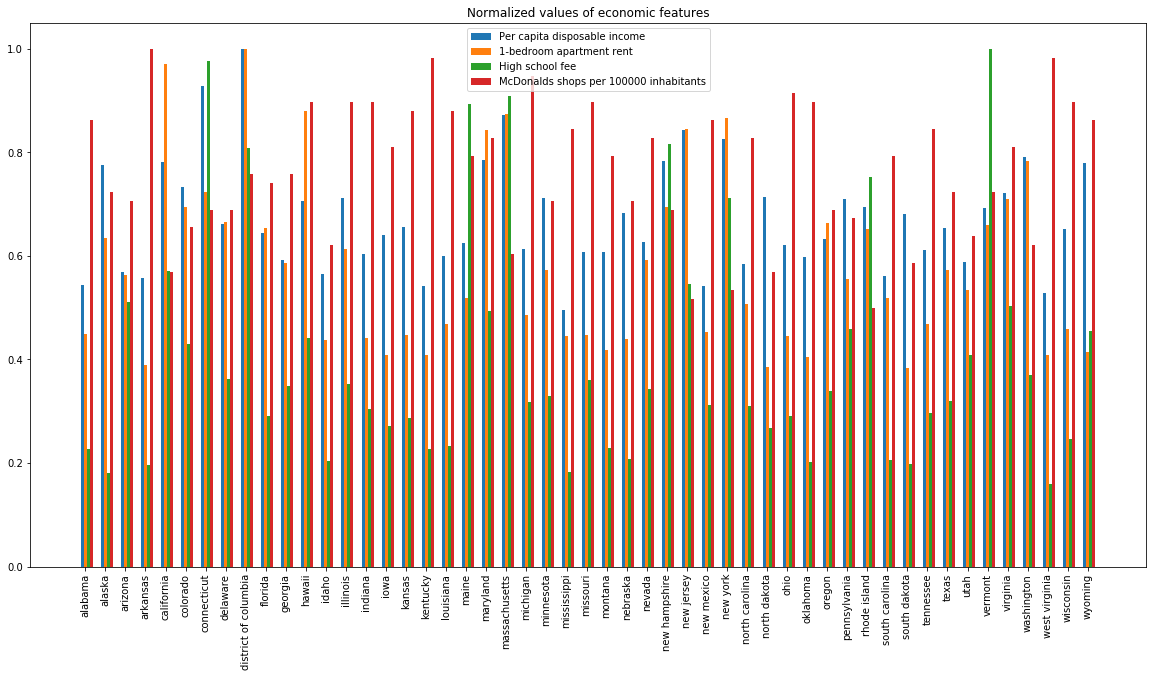

In [92]:
# We plot our economic features
plt.figure(figsize=(20,10))
plt.title("Normalized values of economic features")
barWidth = 0.15
r1 = np.arange(len(df_education_final.State))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
plt.bar(r1, (df_economy_final.Per_capita_income)/(df_economy_final.Per_capita_income.max()), width=0.15) 
plt.bar(r2, (df_economy_final.Price_2018_1br)/(df_economy_final.Price_2018_1br.max()), width=0.15) 
plt.bar(r3, (df_economy_final.High_School_Fee)/(df_economy_final.High_School_Fee.max()), width=0.15)
plt.bar(r4, (df_economy_final.mc_donalds_per_100k)/(df_economy_final.mc_donalds_per_100k.max()), width=0.15)
plt.xticks([r + barWidth for r in range(len(df_education_final.State))], df_education_final.State, 
           rotation='vertical')
plt.gca().legend(('Per capita disposable income', '1-bedroom apartment rent', 'High school fee',
                  'McDonalds shops per 100000 inhabitants'))
plt.savefig("plots/income_1bdr_high_school_fees_mc_donalds.jpg", dpi=200)
plt.show()

Even with some exceptions, these trends are respected! We expect good results in the economic score from District of Columbia, Massachussets, California, but also Connecticut or Vermont, and bad results from Arkansas, Mississippi or New Mexico!

### Things we still need to do
- Implement a ML model on our normalized features to obtain a "economy" score
- Once this score is calculated, generate a map showing the economy score for each state

## Are economy and security related?

As said whan talking about Homeless people, poverty is one of the main motivations that can push to criminality. The necessity for survival could bring to commit crimes.
This is not a way of justifying criminality, but let's see if we can assume this relation as true!

We evaluate the relationship between personal income and property crime rates, in order to analyze this correlation.

In [93]:
plot_plotly_scatter(x=df_economy_final.Per_capita_income,
                   y=df_security_final.Property_crime,
                   marker=df_economy_final.State,
                   title="Poverty vs criminality",
                   output_file="plots/poverty_vs_criminality_plotly.html",
                   xlabel="Disposable personal income",
                   ylabel="Property crimes average rate")

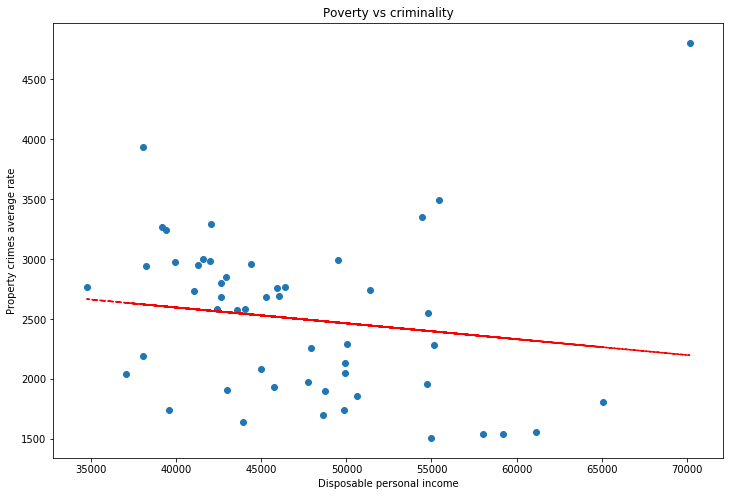

In [94]:
plt.figure(figsize=(12,8))
plt.title("Poverty vs criminality")
plt.xlabel("Disposable personal income")
plt.ylabel("Property crimes average rate")
z = np.polyfit(df_economy_final.Per_capita_income, df_security_final.Property_crime, 1)
p = np.poly1d(z)
plt.plot(df_economy_final.Per_capita_income,p(df_economy_final.Per_capita_income), "r--")
plt.scatter(df_economy_final.Per_capita_income, df_security_final.Property_crime)
plt.savefig("plots/poverty_vs_criminality.jpg", dpi=200)

The correlation is not as strong as expected! 

##### Inventiamo qualcosa per la datastory o balziamo il paragrafo

#### References

- [1] https://en.wikipedia.org/wiki/Human_Development_Index
- [2] https://en.wikipedia.org/wiki/Obesity
- [3] https://en.wikipedia.org/wiki/Utah
- [4] https://en.wikipedia.org/wiki/Word_of_Wisdom
- [5] https://en.wikipedia.org/wiki/Crime_in_the_United_States
- [6] https://link.springer.com/referenceworkentry/10.1007%2F1-4020-3266-8_61
- [7] https://en.wikipedia.org/wiki/Crime_in_Norway
- [8] https://www.investopedia.com/terms/d/disposableincome.asp